In [1]:
%matplotlib notebook

In [2]:
import sys, os, time, gc, click, logging, pprint
from os.path import expanduser
from collections import defaultdict
import numpy as np
from mpi4py import MPI
import neuroh5
from neuroh5.io import append_cell_attributes, read_population_ranges, bcast_cell_attributes, \
    scatter_read_cell_attributes, read_cell_attribute_selection, NeuroH5ProjectionGen
import h5py
import matplotlib.pyplot as plt


In [3]:
user_home = expanduser("~")
neuron_home = '%s/bin/nrnpython3/lib/python' % user_home
#neuron_home = '/Users/milsteina/neuron/nrn_py3/lib/python'
model_home = '%s/src/model' % user_home
#model_home = '/Users/milsteina/PycharmProjects/'
dentate_home = '%s/dentate' % model_home
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import dentate
from dentate.env import Env
from dentate import utils, stimulus, synapses
from dentate.utils import *

In [4]:
template_paths='%s/templates' % dentate_home
dataset_prefix='%s/datasets' % dentate_home
config_prefix='%s/config' % dentate_home


In [5]:
synapse_name='AMPA'
config_file='Network_Clamp_GC_Exc_Sat_SLN_IN_Izh_proximal_pf.yaml'
output_weights_namespace='Structured Weights'
h5types_path=f'{dataset_prefix}/dentate_h5types.h5'
connections_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'
input_features_path=f'{dataset_prefix}/Full_Scale_Control/DG_input_features_20200910_compressed.h5'
initial_weights_namespace="Log-Normal Weights"  
initial_weights_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'
non_structured_weights_namespace="Normal Weights"  
non_structured_weights_path=f'{dataset_prefix}/Slice/dentatenet_Slice_SLN_proximal_pf_20210924.h5'

arena_id='A' 
use_arena_margin=True
coordinates=(None, None) 
optimize_tol=1e-3
optimize_grad=True
max_delta_weight=10
field_width_scale = 1.25
target_amplitude=10.0
initial_weight_decay_fraction=0.5


In [6]:
np.seterr(all='raise')
os.chdir(dentate_home)
env = Env(config_prefix=config_prefix,config_file=config_file,template_paths=template_paths,dataset_prefix=dataset_prefix)


In [7]:
def get_input_arrays(structured_weights_dict, gid):

    target_map = structured_weights_dict[gid]['target_map']
    initial_weight_dict = structured_weights_dict[gid]['initial_weight_dict']
    input_rate_map_dict = structured_weights_dict[gid]['input_rate_map_dict']
    non_structured_input_rate_map_dict = structured_weights_dict[gid]['non_structured_input_rate_map_dict']
    non_structured_weights_dict = structured_weights_dict[gid]['non_structured_weight_dict']
    syn_count_dict = structured_weights_dict[gid]['syn_count_dict']
    arena_x = structured_weights_dict[gid]['arena_x']
    arena_y = structured_weights_dict[gid]['arena_y']

    input_matrix = np.empty((target_map.size, len(input_rate_map_dict)),
                            dtype=np.float64)
    source_gid_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    syn_count_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
    initial_weight_array = np.empty(len(input_rate_map_dict), dtype=np.float64)
    for i, source_gid in enumerate(input_rate_map_dict):
        source_gid_array[i] = source_gid
        this_syn_count = syn_count_dict[source_gid]
        this_input = input_rate_map_dict[source_gid].ravel() * this_syn_count
        input_matrix[:, i] = this_input
        syn_count_array[i] = this_syn_count
        initial_weight_array[i] = initial_weight_dict[source_gid]


    non_structured_input_matrix = None
    if non_structured_input_rate_map_dict is not None:
        non_structured_input_matrix = np.empty((target_map.size, len(non_structured_input_rate_map_dict)),
                                    dtype=np.float32)
        non_structured_weight_array = np.empty(len(non_structured_input_rate_map_dict), dtype=np.float32)
        for i, source_gid in enumerate(non_structured_input_rate_map_dict):
            this_syn_count = syn_count_dict[source_gid]
            this_input = non_structured_input_rate_map_dict[source_gid].ravel() * this_syn_count
            non_structured_input_matrix[:, i] = this_input
            non_structured_weight_array[i] = non_structured_weights_dict.get(source_gid, 1.0)

    return {'target_map': target_map,
            'input_matrix': input_matrix, 
            'initial_weight_array': initial_weight_array, 
            'non_structured_input_matrix': non_structured_input_matrix, 
            'non_structured_weight_array': non_structured_weight_array, 
            'syn_count_array': syn_count_array, 
            'source_gid_array': source_gid_array}


In [8]:
def get_scaled_input_maps(target_amplitude, structured_weights_dict, gid):
    
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    
    target_map = input_arrays_dict['target_map']
    initial_weight_array = input_arrays_dict['initial_weight_array']
    input_matrix = input_arrays_dict['input_matrix']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']
    non_structured_input_matrix = np.asarray(input_arrays_dict['non_structured_input_matrix'], dtype=np.float64)
    
    mean_initial_weight = np.mean(initial_weight_array)
    initial_background_map = np.dot(input_matrix, initial_weight_array) + \
                             np.dot(non_structured_input_matrix, non_structured_weight_array)
    if np.mean(initial_background_map)<= 0.:
       raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')

    mean_initial_background = np.mean(initial_background_map)
    scaled_background_map = initial_background_map / mean_initial_background
    scaled_background_map -= 1.
    # I don't think the min of target_map should be subtracted here. If a target map has nonzero background, we need
    # structured weights to provide that (e.g. very wide fields or multiple fields)
    # scaled_target_map = np.asarray(target_map.flat - np.min(target_map), dtype=np.float64)
    scaled_target_map = np.asarray(target_map.flat, dtype=np.float64)

    if np.max(scaled_target_map) > 0.:
       target_map_scaling_factor = target_amplitude / np.max(target_map)
       scaled_target_map = scaled_target_map.flat * target_map_scaling_factor
    flat_scaled_target_map = scaled_target_map.ravel()

    scaled_input_matrix = input_matrix / mean_initial_background
    scaled_non_structured_input_matrix = non_structured_input_matrix / mean_initial_background

    return {'scaled_input_matrix' : scaled_input_matrix,
            'scaled_non_structured_input_matrix': scaled_non_structured_input_matrix,
            'flat_scaled_target_map': flat_scaled_target_map,
            'scaled_background_map': scaled_background_map,
            'initial_background_map': initial_background_map,
            'mean_initial_background': mean_initial_background,
            'mean_initial_weight': mean_initial_weight
           }
    

# The activity of the inputs is designed to be uniform inside the arena. By adding an additional arena margin,
# you are revealing a decrease in mean input activity at the margins. Perhaps the mean could be calculated only
# within arena.

In [18]:
def activation_map_residual(delta_weights, input_matrix, target_map):
    a = np.dot(input_matrix, delta_weights)
    e = np.subtract(target_map, a)
                                           
    res = np.square(e).mean() / 2.
    return np.asarray(res, dtype=np.float64)

def activation_map_residual_grad(weights, input_matrix, target_map):
    N = weights.shape[0]
    a = np.dot(input_matrix, weights)
    e = np.subtract(target_map, a)
    grad = -1./N * np.dot(input_matrix.T, e)
    return np.asarray(grad, dtype=np.float64)


# Structured weights configuration for MC

In [9]:


destination = 'MC'
sources = ['CA3c']
non_structured_sources = ['MC', 'GC']  # []


target_gid_set = set([1008431, 1021757, 1011284])


In [10]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
all_sources = sources + non_structured_sources


In [11]:


connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception(f'destination: {destination}; gid {this_gid} not matched across multiple attribute '
                            f'generators: {[attr_gen_items[0] for attr_gen_items in attr_gen_package]}')

        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            print(input_features_namespace, destination, selection)
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {destination}')

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())
        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info(f'destination: {destination}; read initial synaptic weights for {initial_weights_gid_count} gids')
            
        if len(non_structured_sources) > 0:
            non_structured_weights_by_syn_id_dict = defaultdict(lambda: dict())
            non_structured_weights_by_source_gid_dict = defaultdict(lambda: dict())
        else:
            non_structured_weights_by_syn_id_dict = None
            
        if non_structured_weights_path is not None:
            non_structured_weights_iter = \
                read_cell_attribute_selection(initial_weights_path, destination,
                                              namespace=non_structured_weights_namespace,
                                              selection=selection)

            non_structured_weights_gid_count = 0
            non_structured_weights_syn_count = 0
            for this_gid, syn_weight_attr_dict in non_structured_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    non_structured_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                non_structured_weights_gid_count += 1
                non_structured_weights_syn_count += len(syn_ids)     

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                this_non_structured_weights_by_syn_id_dict = None
                this_non_structured_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    this_non_structured_weights_by_syn_id_dict = non_structured_weights_by_syn_id_dict[destination_gid]
                    this_non_structured_weights_by_source_gid_dict = non_structured_weights_by_source_gid_dict[destination_gid]


                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    if this_syn_id in this_initial_weights_by_syn_id_dict:
                        this_syn_wgt = this_initial_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_initial_weights_by_source_gid_dict:
                            this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                        
                    elif this_syn_id in this_non_structured_weights_by_syn_id_dict:
                        this_syn_wgt = this_non_structured_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_non_structured_weights_by_source_gid_dict:
                            this_non_structured_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    
                    count += 1
                if source not in non_structured_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info(f'destination: {destination}; gid {this_gid}; {count} edges from source population {source}')



        input_rate_maps_by_source_gid_dict = {}
        if len(non_structured_sources) > 0:
            non_structured_input_rate_maps_by_source_gid_dict = {}
        else:
            non_structured_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info(f'Reading {input_features_namespace} feature data for {len(source_gids)} cells in population {source}...')
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in non_structured_sources:
                        non_structured_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {source}')

        if has_structured_weights:

            structured_weights_dict[this_gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': initial_weights_by_source_gid_dict[this_gid],
                 'non_structured_weight_dict': non_structured_weights_by_source_gid_dict[this_gid],
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'non_structured_input_rate_map_dict': non_structured_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



Place Selectivity A MC [1011284]
Grid Selectivity A MC [1011284]
Place Selectivity A MC [1021757]
Grid Selectivity A MC [1021757]
Place Selectivity A MC [1008431]
Grid Selectivity A MC [1008431]


<IPython.core.display.Javascript object>


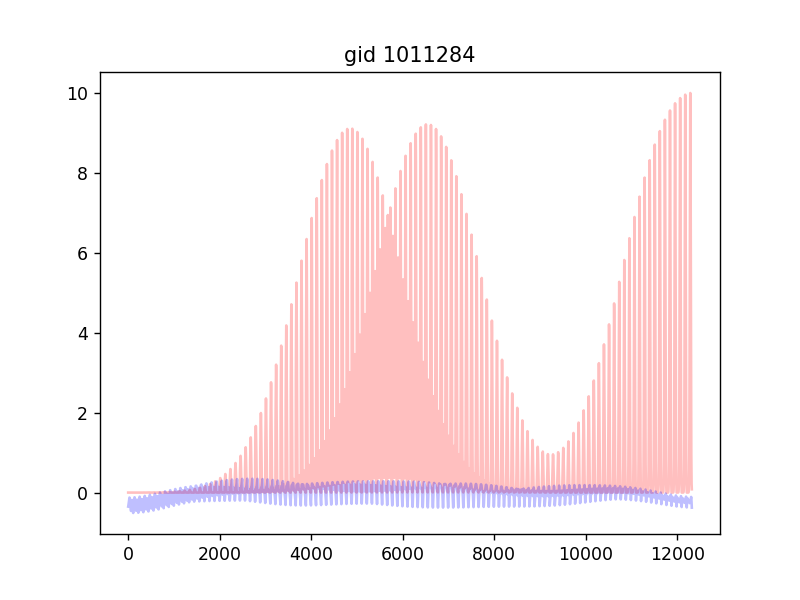

<IPython.core.display.Javascript object>


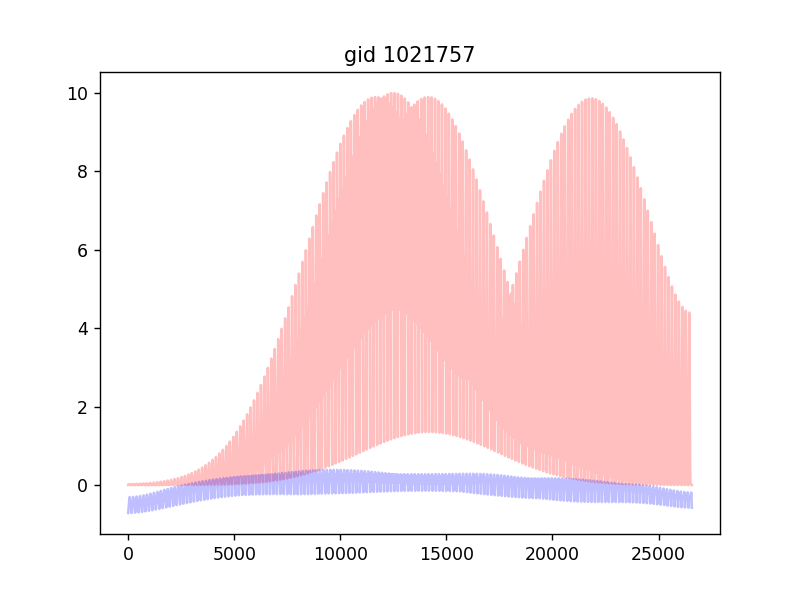

<IPython.core.display.Javascript object>


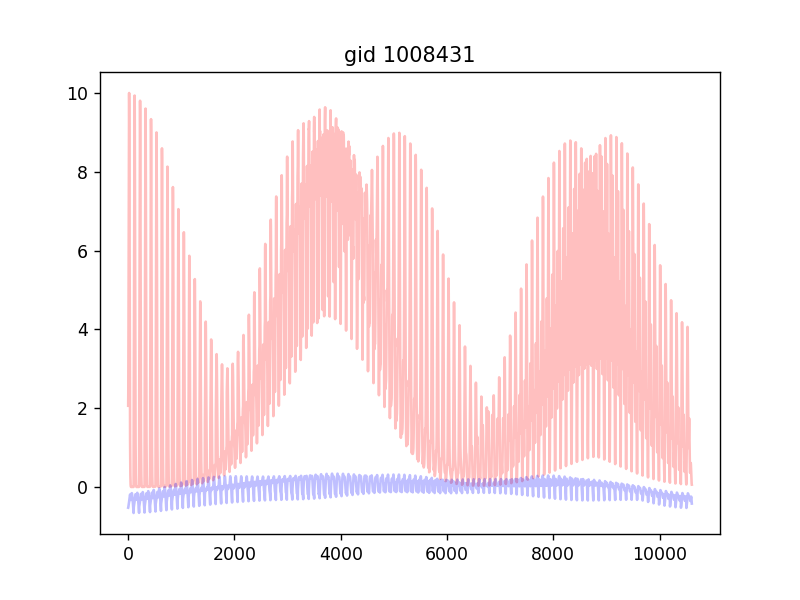

In [33]:

scaled_maps_dict = { gid: get_scaled_input_maps (target_amplitude, structured_weights_dict, gid) 
                   for gid, structured_weights in structured_weights_dict.items() }

for gid, scaled_maps in scaled_maps_dict.items():
    plt.figure()
    plt.title(f"gid {gid}")
    flat_scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    plt.plot(flat_scaled_target_map, c='r', alpha=0.25)
    plt.plot(scaled_background_map, c='b', alpha=0.25)

In [34]:
lsqr_dict = {}
for gid, scaled_maps in scaled_maps_dict.items():
    scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']

    lsqr_target_map = scaled_target_map - scaled_background_map

    res = scipy.sparse.linalg.lsmr(scaled_input_matrix,
                                   lsqr_target_map, maxiter=1000,
                                   damp=0.1, show=True)
    lsqr_delta_weights = np.asarray(res[0], dtype=np.float32)    
    
    lsqr_dict[gid] = {'lsqr_delta_weights': lsqr_delta_weights,
                       'lsqr_target_map': lsqr_target_map}


 
LSMR            Least-squares solution of  Ax = b

The matrix A has 12321 rows and 143 columns
damp = 1.00000000000000e-01

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1000

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.729e+02  2.298e+02   1.0e+00  3.1e-03
     1  0.00000e+00  2.216e+02  1.165e+02   8.1e-01  3.8e-01  1.4e+00  1.0e+00
     2  0.00000e+00  1.594e+02  6.117e+01   5.8e-01  2.1e-01  1.8e+00  2.1e+00
     3  0.00000e+00  1.203e+02  3.426e+01   4.4e-01  1.4e-01  2.0e+00  2.7e+00
     4  0.00000e+00  1.028e+02  2.326e+01   3.8e-01  1.0e-01  2.2e+00  2.9e+00
     5  0.00000e+00  8.920e+01  1.491e+01   3.3e-01  7.2e-02  2.3e+00  3.2e+00
     6  0.00000e+00  8.299e+01  1.098e+01   3.0e-01  5.4e-02  2.4e+00  3.4e+00
     7  0.00000e+00  7.712e+01  7.122e+00   2.8e-01  3.6e-02  2.6e+00  3.9e+00
     8  0.00000e+00  7.473e+01  5.193e+00   2.7e-01  2.6e-02  2.6e+00  4.0e+00
 

<IPython.core.display.Javascript object>


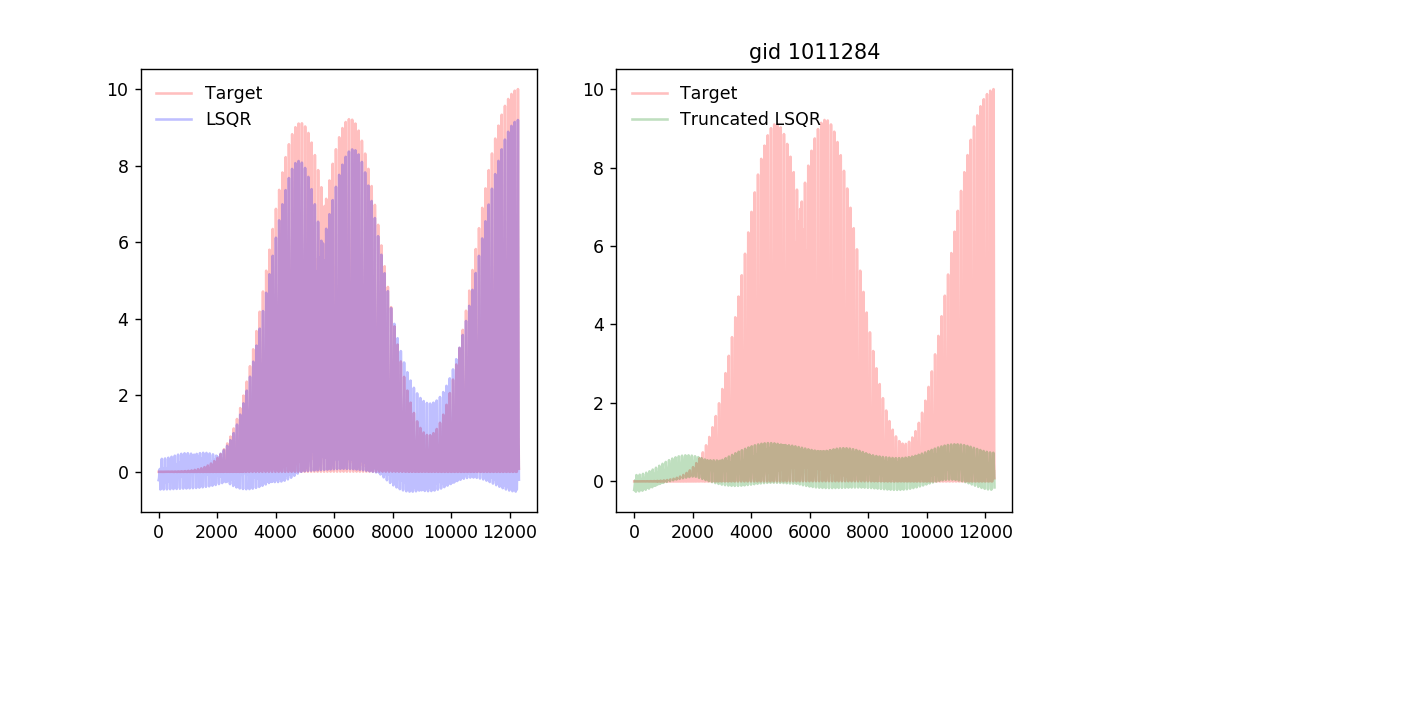

<IPython.core.display.Javascript object>


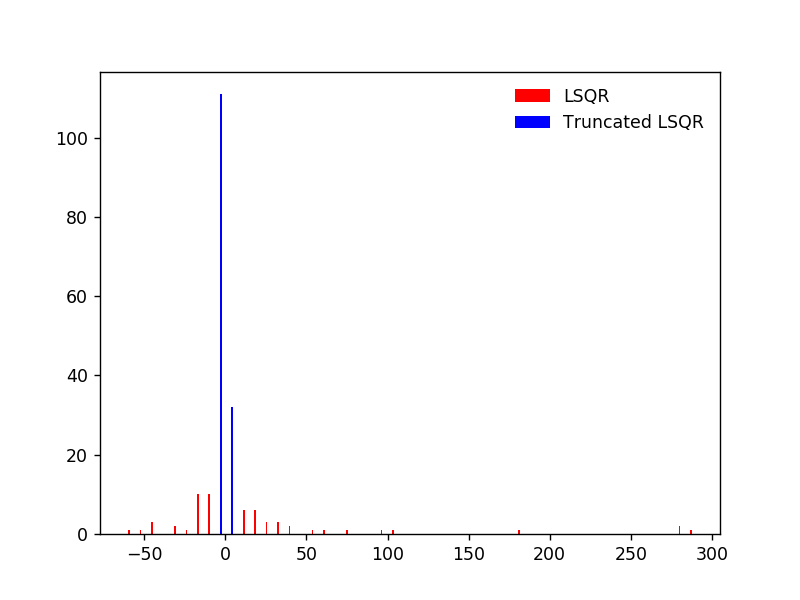

<IPython.core.display.Javascript object>


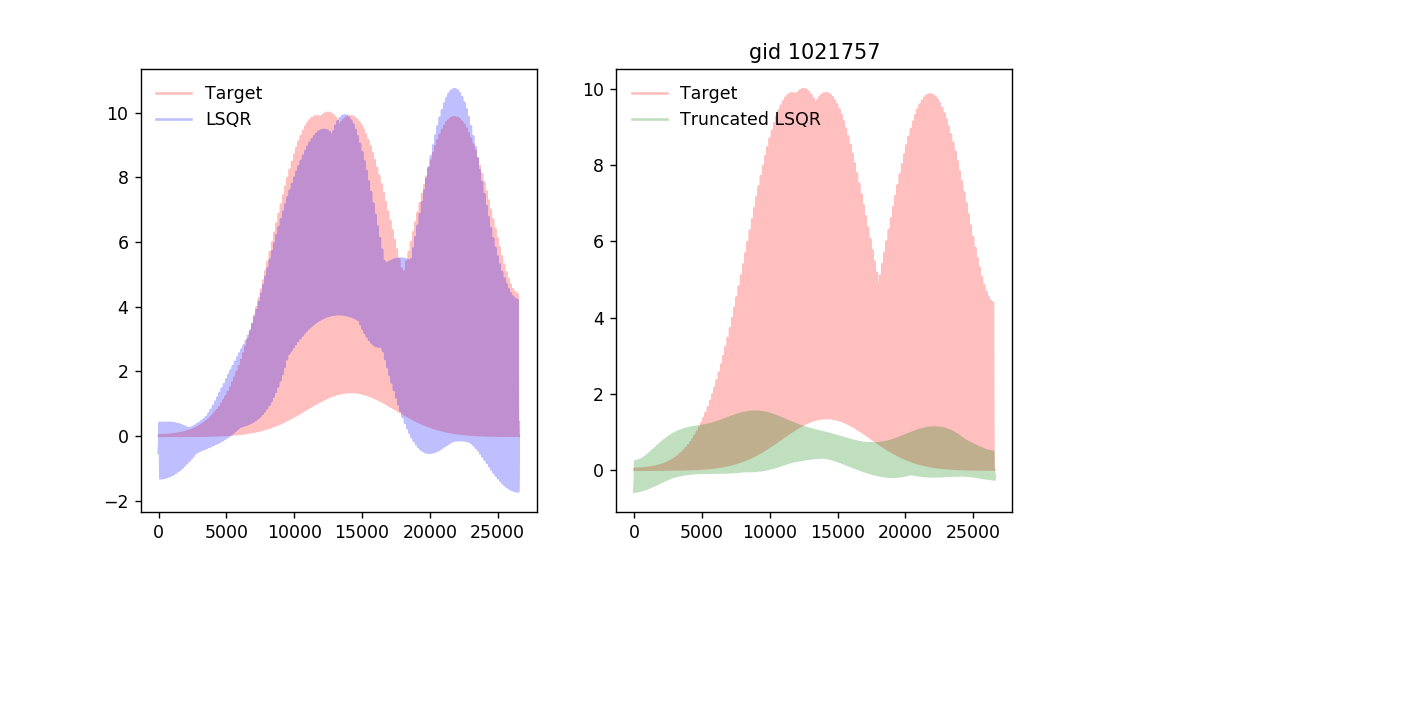

<IPython.core.display.Javascript object>


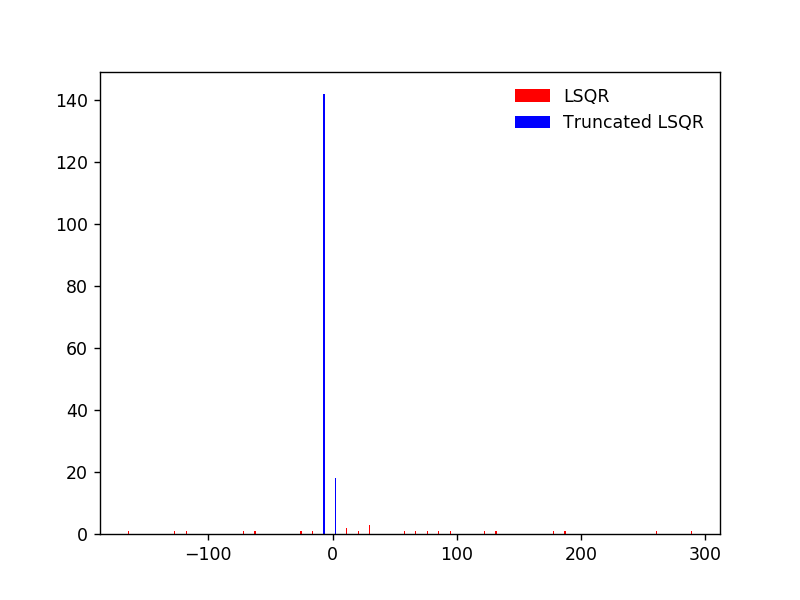

<IPython.core.display.Javascript object>


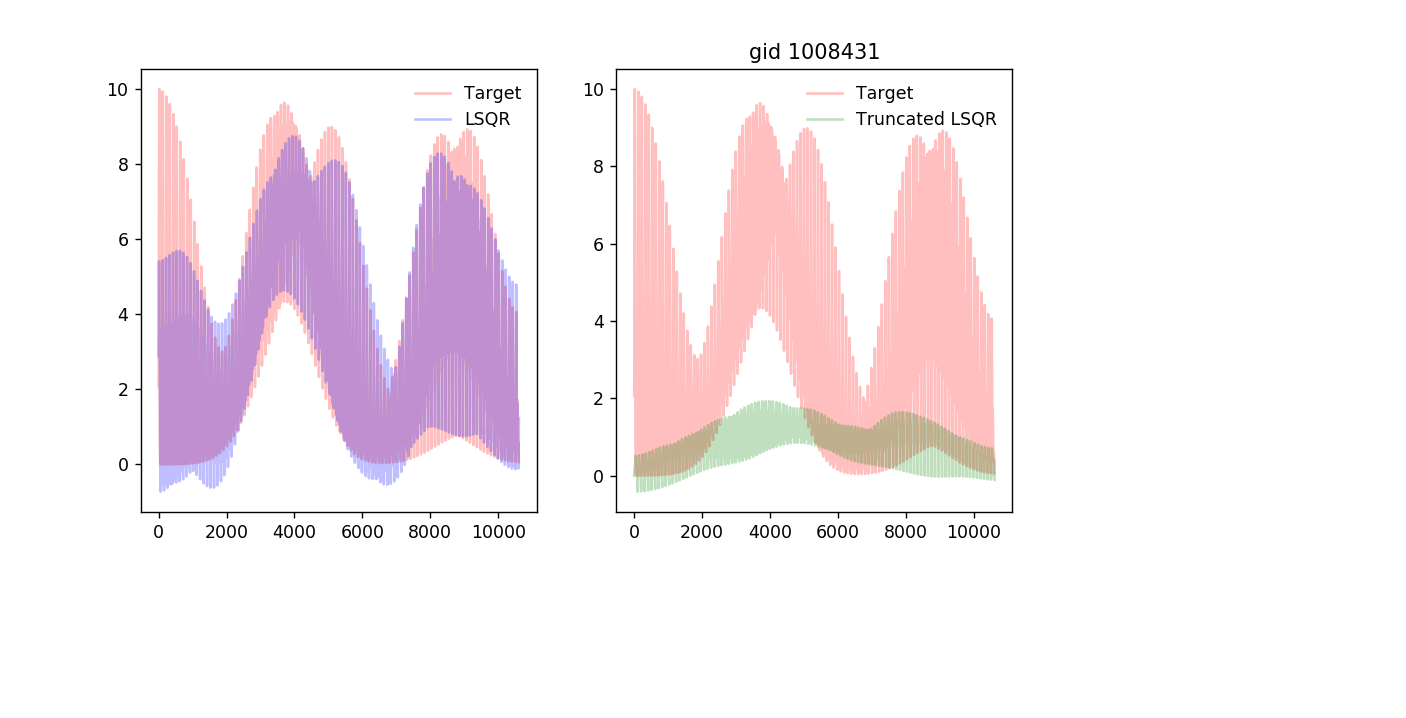

<IPython.core.display.Javascript object>


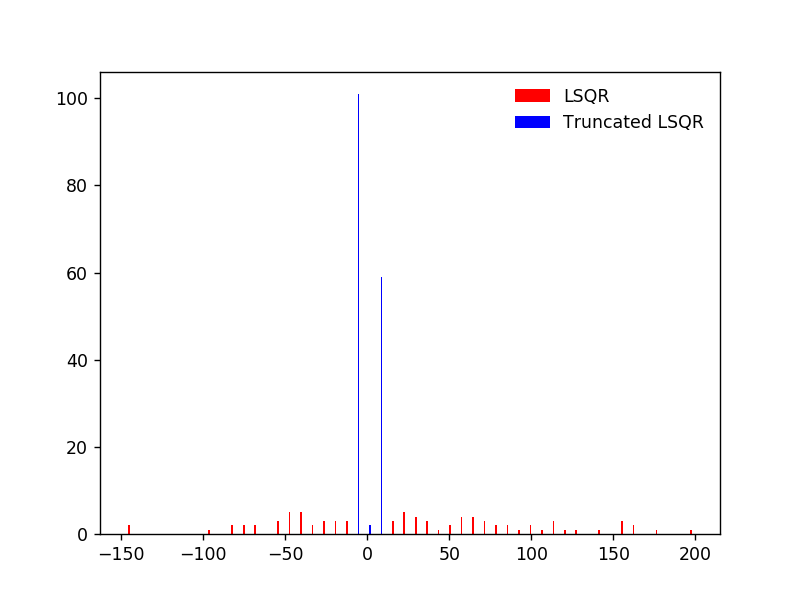

In [40]:
for gid, lsqr_arrays in lsqr_dict.items():

    lsqr_delta_weights = lsqr_arrays['lsqr_delta_weights']
    scaled_maps = scaled_maps_dict[gid]
    scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']
    scaled_non_structured_input_matrix = scaled_maps['scaled_non_structured_input_matrix']
    
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    initial_weight_array = input_arrays_dict['initial_weight_array']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']

    lb = 0.
    ub = max_delta_weight
    initial_LS_bounds = (lb, ub)
    initial_LS_delta_weights = np.clip(lsqr_delta_weights, initial_LS_bounds[0], initial_LS_bounds[1])
    lsqr_arrays['initial_LS_delta_weights'] = initial_LS_delta_weights

    lsqr_map = np.dot(scaled_input_matrix, lsqr_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        lsqr_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        initial_LS_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)

    
    fig, axes = plt.subplots(1, 2, figsize=(9., 4.6))
    plt.title(f'gid {gid}')
    axes[0].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[1].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[0].plot(lsqr_map, c='b', alpha=0.25, label='LSQR')
    axes[1].plot(initial_LS_map, c='g', alpha=0.25, label='Truncated LSQR')
    axes[0].legend(loc='best', frameon=False, framealpha=0.5)
    axes[1].legend(loc='best', frameon=False, framealpha=0.5)

    plt.figure()
    hist, edges = np.histogram(lsqr_delta_weights, bins=50)
    plt.bar(edges[:-1], hist, color='r', width=1, label='LSQR')
    hist, edges = np.histogram(initial_LS_delta_weights, bins=edges)
    plt.bar(edges[:-1], hist, color='b', width=1, label='Truncated LSQR')
    plt.legend(loc='best', frameon=False, framealpha=0.5)


In [42]:
import scipy.optimize as opt
optimize_method = 'L-BFGS-B'

method_options = {'disp': True, 'maxiter': 1000}
method_options['maxfun'] = 1000000

LS_weights_dict = {}
for gid, lsqr_arrays in lsqr_dict.items():
    lsqr_target_map = lsqr_arrays['lsqr_target_map']
    initial_LS_delta_weights = lsqr_arrays['initial_LS_delta_weights']
    scaled_input_matrix = scaled_maps_dict[gid]['scaled_input_matrix']
    result = opt.minimize(activation_map_residual,
                          initial_LS_delta_weights, 
                          jac=activation_map_residual_grad if optimize_grad else None,
                          args=(scaled_input_matrix, lsqr_target_map.flat),
                          method=optimize_method,
                          bounds=[initial_LS_bounds for x in initial_LS_delta_weights],
                          tol=optimize_tol,
                          options=method_options)
    LS_weights_dict[gid]  = {'LS_delta_weights': np.array(result.x)}


max_delta_weight would have to increase to 63.4 to reach target_amplitude


<IPython.core.display.Javascript object>


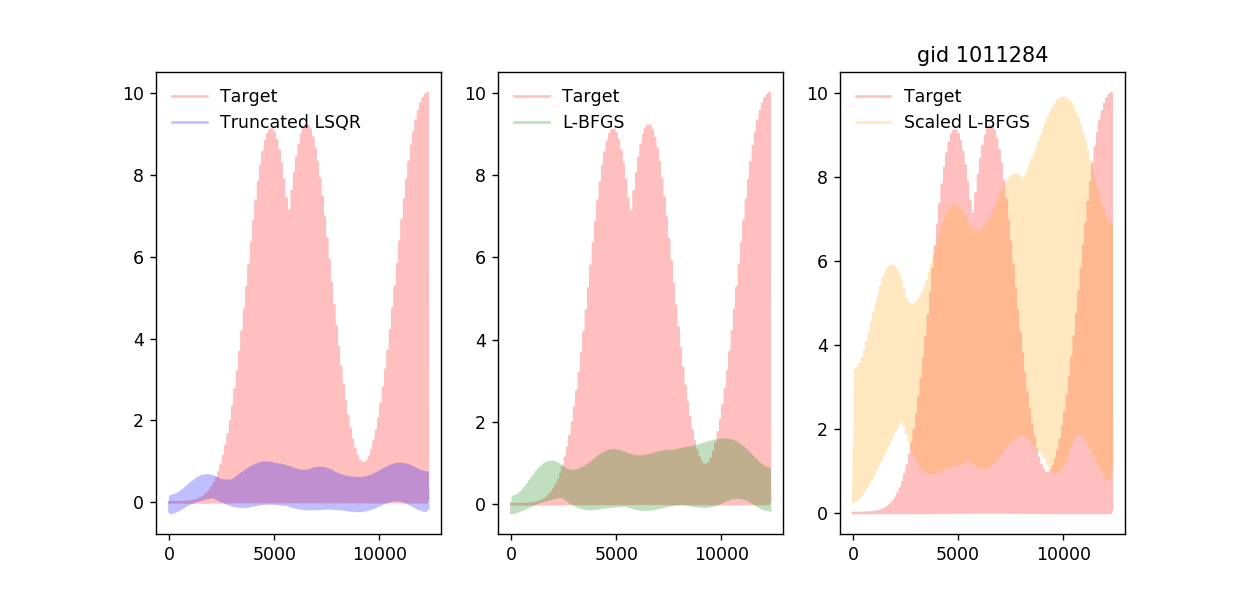

<IPython.core.display.Javascript object>


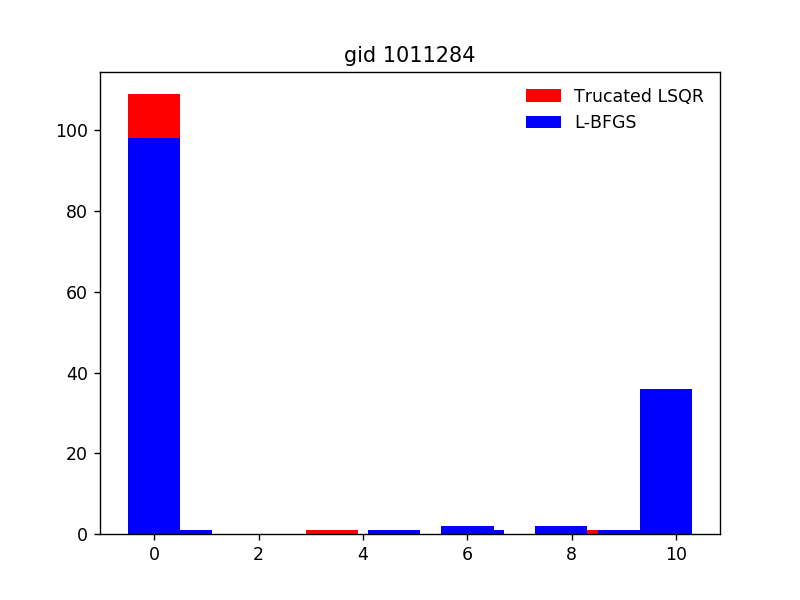

max_delta_weight would have to increase to 37.8 to reach target_amplitude


<IPython.core.display.Javascript object>


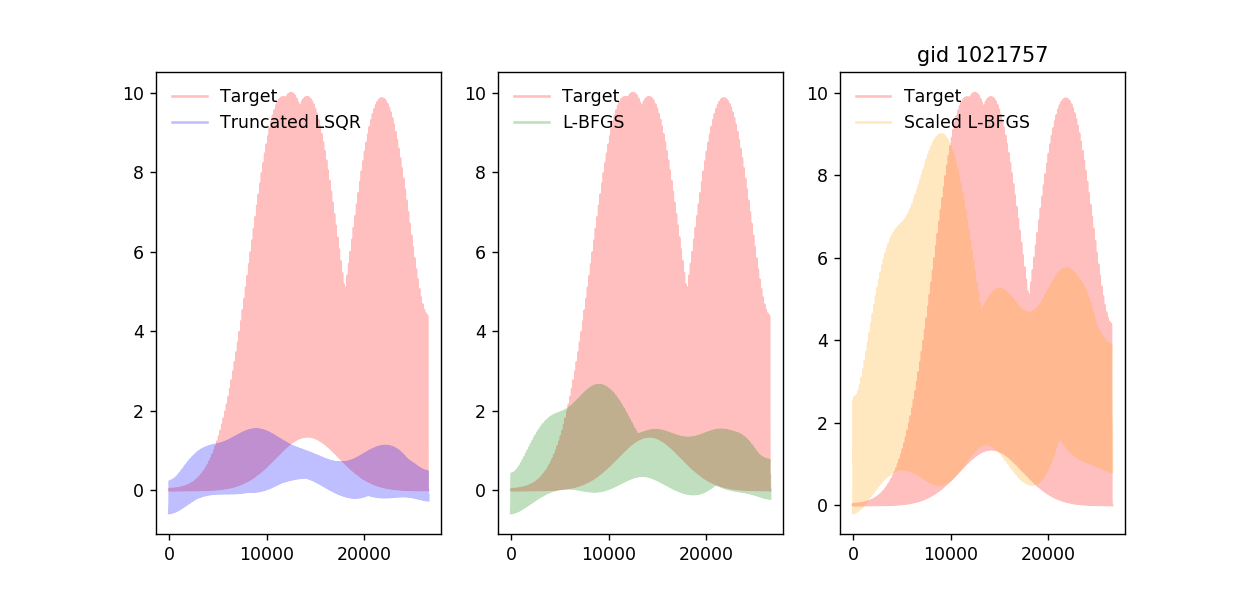

<IPython.core.display.Javascript object>


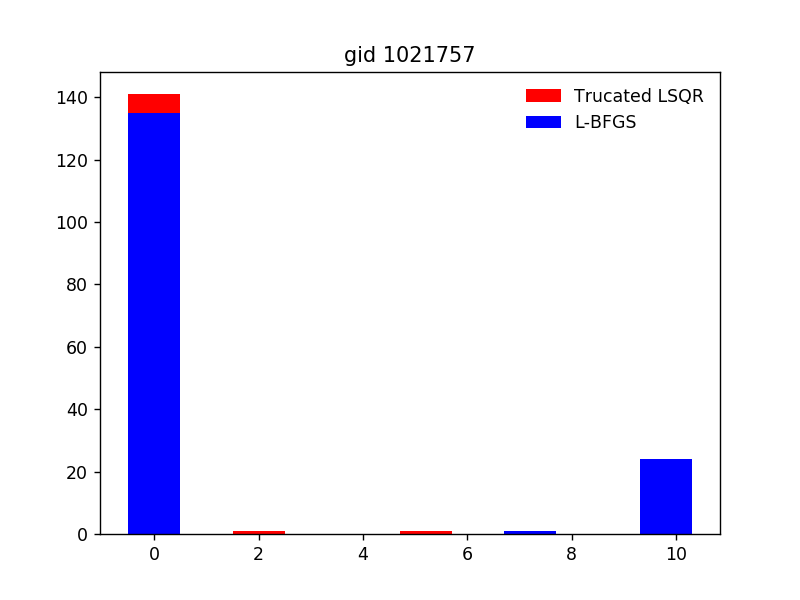

max_delta_weight would have to increase to 35.7 to reach target_amplitude


<IPython.core.display.Javascript object>


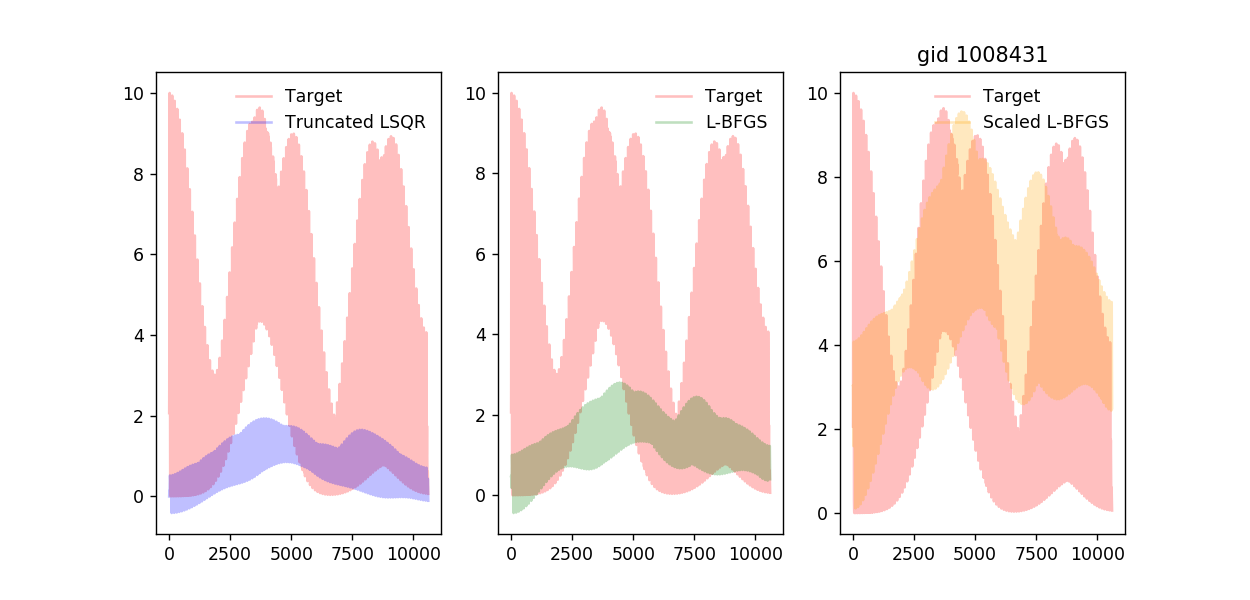

<IPython.core.display.Javascript object>


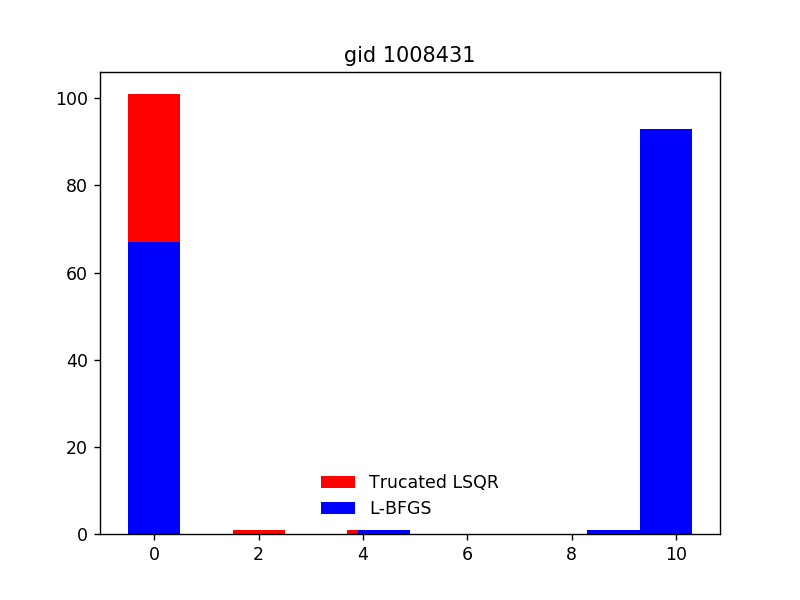

In [44]:
for gid, LS_arrays in LS_weights_dict.items():
    
    LS_delta_weights = LS_arrays['LS_delta_weights']
    
    scaled_maps = scaled_maps_dict[gid]
    scaled_input_matrix = scaled_maps['scaled_input_matrix']
    scaled_non_structured_input_matrix = scaled_maps['scaled_non_structured_input_matrix']
    scaled_target_map = scaled_maps['flat_scaled_target_map']
 
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    initial_weight_array = input_arrays_dict['initial_weight_array']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']

    lsqr_arrays = lsqr_dict[gid]
    initial_LS_delta_weights = lsqr_arrays['initial_LS_delta_weights']

    LS_delta_map = np.dot(scaled_input_matrix, LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        LS_delta_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)

    
    initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        initial_LS_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    
    normalized_delta_weights_array = LS_delta_weights / np.max(LS_delta_weights)
    scaled_LS_delta_weights = LS_delta_weights * target_amplitude / np.max(LS_delta_map)
    
    scaled_LS_delta_map = np.dot(scaled_input_matrix, scaled_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        scaled_LS_delta_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    print('max_delta_weight would have to increase to %.1f to reach target_amplitude' % (np.max(scaled_LS_delta_weights))) 

    fig, axes = plt.subplots(1, 3, figsize=(10., 4.8))
    plt.title('gid %d' % gid)
    axes[0].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[1].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[2].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[0].plot(initial_LS_map, c='b', alpha=0.25, label="Truncated LSQR")
    axes[1].plot(LS_delta_map, c='g', alpha=0.25, label="L-BFGS")
    axes[2].plot(scaled_LS_delta_map, c='orange', alpha=0.25, label="Scaled L-BFGS")
    axes[0].legend(loc='best', frameon=False, framealpha=0.5)
    axes[1].legend(loc='best', frameon=False, framealpha=0.5)
    axes[2].legend(loc='best', frameon=False, framealpha=0.5)

    plt.figure()
    plt.title('gid %d' % gid)
    hist, edges = np.histogram(initial_LS_delta_weights, bins=50)
    plt.bar(edges[:-1], hist, color='r', width=1, label='Trucated LSQR')
    hist, edges = np.histogram(LS_delta_weights, bins=edges)
    plt.bar(edges[:-1], hist, color='b', width=1, label='L-BFGS')
    plt.legend(loc='best', frameon=False, framealpha=0.5)

# Structured weights configuration for GC

In [12]:


destination = 'GC'
sources = ['MPP', 'LPP']
non_structured_sources = ['MC', 'ConMC']  # []


target_gid_set = set([10411, 52479, 125066, 204202, 313753])


In [13]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
all_sources = sources + non_structured_sources


In [14]:


connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception(f'destination: {destination}; gid {this_gid} not matched across multiple attribute '
                            f'generators: {[attr_gen_items[0] for attr_gen_items in attr_gen_package]}')

        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            print(input_features_namespace, destination, selection)
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {destination}')

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())
        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info(f'destination: {destination}; read initial synaptic weights for {initial_weights_gid_count} gids')
            
        if len(non_structured_sources) > 0:
            non_structured_weights_by_syn_id_dict = defaultdict(lambda: dict())
            non_structured_weights_by_source_gid_dict = defaultdict(lambda: dict())
        else:
            non_structured_weights_by_syn_id_dict = None
            
        if non_structured_weights_path is not None:
            non_structured_weights_iter = \
                read_cell_attribute_selection(initial_weights_path, destination,
                                              namespace=non_structured_weights_namespace,
                                              selection=selection)

            non_structured_weights_gid_count = 0
            non_structured_weights_syn_count = 0
            for this_gid, syn_weight_attr_dict in non_structured_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    non_structured_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                non_structured_weights_gid_count += 1
                non_structured_weights_syn_count += len(syn_ids)     

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                this_non_structured_weights_by_syn_id_dict = None
                this_non_structured_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    this_non_structured_weights_by_syn_id_dict = non_structured_weights_by_syn_id_dict[destination_gid]
                    this_non_structured_weights_by_source_gid_dict = non_structured_weights_by_source_gid_dict[destination_gid]


                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    if this_syn_id in this_initial_weights_by_syn_id_dict:
                        this_syn_wgt = this_initial_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_initial_weights_by_source_gid_dict:
                            this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                        
                    elif this_syn_id in this_non_structured_weights_by_syn_id_dict:
                        this_syn_wgt = this_non_structured_weights_by_syn_id_dict[this_syn_id]
                        if this_source_gid not in this_non_structured_weights_by_source_gid_dict:
                            this_non_structured_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    
                    count += 1
                if source not in non_structured_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info(f'destination: {destination}; gid {this_gid}; {count} edges from source population {source}')



        input_rate_maps_by_source_gid_dict = {}
        if len(non_structured_sources) > 0:
            non_structured_input_rate_maps_by_source_gid_dict = {}
        else:
            non_structured_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info(f'Reading {input_features_namespace} feature data for {len(source_gids)} cells in population {source}...')
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in non_structured_sources:
                        non_structured_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info(f'Read {input_features_namespace} feature data for {count} cells in population {source}')

        if has_structured_weights:

            structured_weights_dict[this_gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': initial_weights_by_source_gid_dict[this_gid],
                 'non_structured_weight_dict': non_structured_weights_by_source_gid_dict[this_gid],
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'non_structured_input_rate_map_dict': non_structured_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



Place Selectivity A GC [313753]
Grid Selectivity A GC [313753]
Place Selectivity A GC [125066]
Grid Selectivity A GC [125066]
Place Selectivity A GC [204202]
Grid Selectivity A GC [204202]
Place Selectivity A GC [10411]
Grid Selectivity A GC [10411]
Place Selectivity A GC [52479]
Grid Selectivity A GC [52479]


<IPython.core.display.Javascript object>


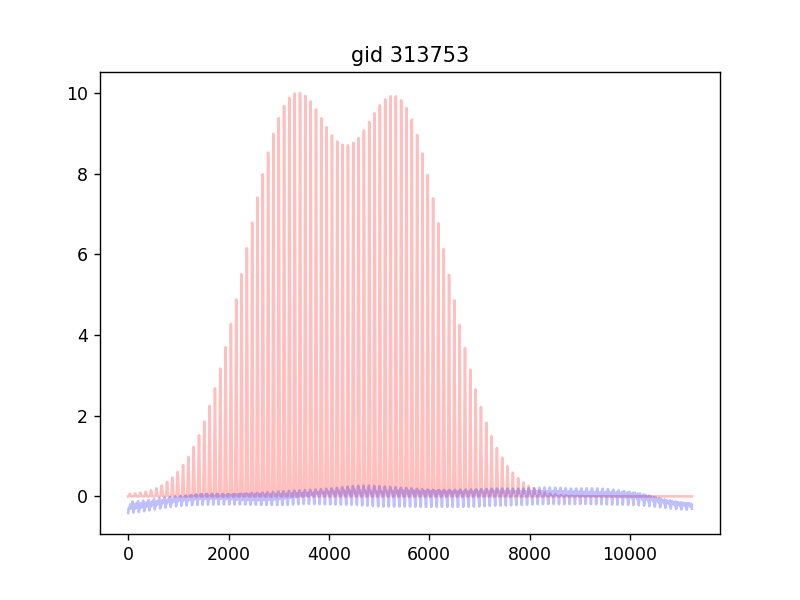

<IPython.core.display.Javascript object>


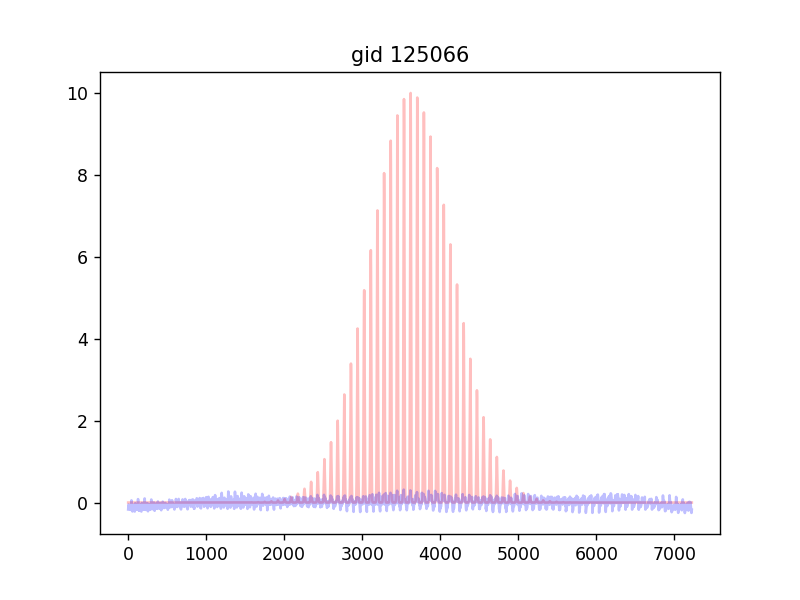

<IPython.core.display.Javascript object>


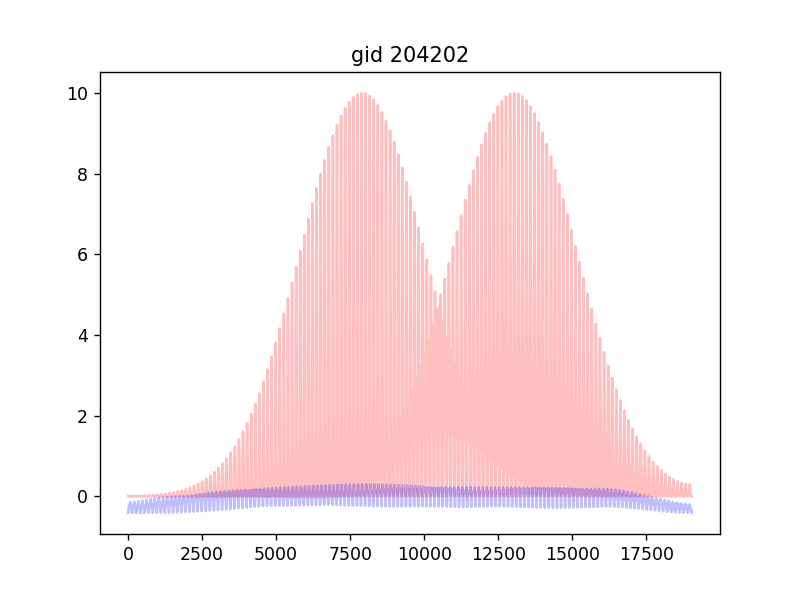

<IPython.core.display.Javascript object>


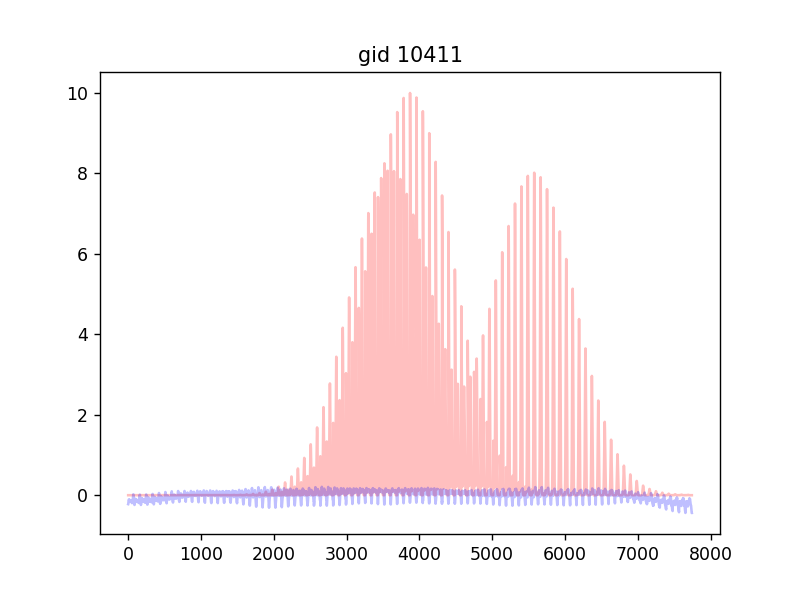

<IPython.core.display.Javascript object>


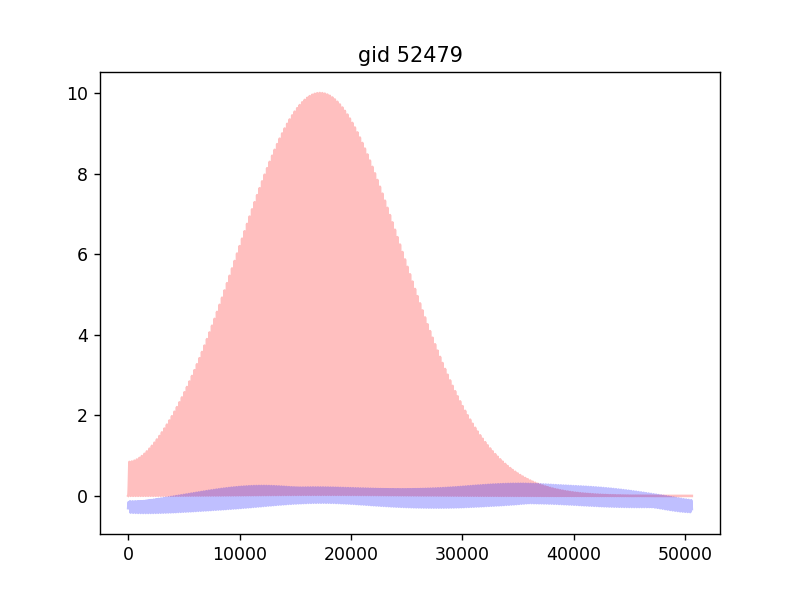

In [15]:

scaled_maps_dict = { gid: get_scaled_input_maps (target_amplitude, structured_weights_dict, gid) 
                   for gid, structured_weights in structured_weights_dict.items() }

for gid, scaled_maps in scaled_maps_dict.items():
    plt.figure()
    plt.title(f"gid {gid}")
    flat_scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    plt.plot(flat_scaled_target_map, c='r', alpha=0.25)
    plt.plot(scaled_background_map, c='b', alpha=0.25)

In [16]:
lsqr_dict = {}
for gid, scaled_maps in scaled_maps_dict.items():
    scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']

    lsqr_target_map = scaled_target_map - scaled_background_map

    res = scipy.sparse.linalg.lsmr(scaled_input_matrix,
                                   lsqr_target_map, maxiter=1000,
                                   damp=0.1, show=True)
    lsqr_delta_weights = np.asarray(res[0], dtype=np.float32)    
    
    lsqr_dict[gid] = {'lsqr_delta_weights': lsqr_delta_weights,
                       'lsqr_target_map': lsqr_target_map}


 
LSMR            Least-squares solution of  Ax = b

The matrix A has 11236 rows and 2126 columns
damp = 1.00000000000000e-01

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1000

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  2.289e+02  3.849e+02   1.0e+00  7.3e-03
     1  3.36729e-05  1.847e+02  1.858e+02   8.1e-01  3.6e-01  2.8e+00  1.0e+00
     2 -7.67382e-01  8.381e+01  5.562e+01   3.7e-01  1.9e-01  3.4e+00  2.8e+00
     3 -3.76853e-01  5.573e+01  2.187e+01   2.4e-01  1.1e-01  3.6e+00  3.5e+00
     4 -1.42137e-01  4.546e+01  1.375e+01   2.0e-01  8.3e-02  3.7e+00  4.9e+00
     5  1.54081e-01  3.784e+01  8.530e+00   1.7e-01  6.0e-02  3.8e+00  5.4e+00
     6  2.72980e-01  3.391e+01  5.423e+00   1.5e-01  4.1e-02  3.9e+00  5.6e+00
     7  3.57011e-01  3.182e+01  3.817e+00   1.4e-01  3.0e-02  3.9e+00  6.6e+00
     8  4.78537e-01  3.061e+01  2.799e+00   1.3e-01  2.3e-02  4.0e+00  6.5e+00


     8 -2.23324e+00  3.542e+01  2.574e+01   6.1e-02  5.1e-02  1.4e+01  5.7e+00
     9 -2.35705e+00  3.166e+01  1.928e+01   5.5e-02  4.2e-02  1.4e+01  5.7e+00
    10 -2.46410e+00  2.889e+01  1.450e+01   5.0e-02  3.4e-02  1.5e+01  6.1e+00
    20 -3.03486e+00  2.121e+01  2.347e+00   3.7e-02  5.6e-03  2.0e+01  1.4e+01
    30 -3.49966e+00  1.958e+01  6.896e-01   3.4e-02  1.5e-03  2.3e+01  2.7e+01
    40 -3.79243e+00  1.930e+01  2.445e-01   3.3e-02  4.7e-04  2.7e+01  1.9e+01
    50 -3.95257e+00  1.925e+01  1.001e-01   3.3e-02  1.7e-04  3.0e+01  2.7e+01
    60 -3.98269e+00  1.924e+01  4.044e-02   3.3e-02  6.4e-05  3.3e+01  2.2e+01
    70 -3.98887e+00  1.924e+01  1.497e-02   3.3e-02  2.2e-05  3.6e+01  2.2e+01
    80 -3.99424e+00  1.924e+01  7.158e-03   3.3e-02  9.8e-06  3.8e+01  2.2e+01
    90 -3.99970e+00  1.924e+01  2.519e-03   3.3e-02  3.2e-06  4.1e+01  2.6e+01
   100 -4.00048e+00  1.924e+01  9.123e-04   3.3e-02  1.1e-06  4.3e+01  2.3e+01
   101 -4.00048e+00  1.924e+01  8.899e-04   3.3e-02 

<IPython.core.display.Javascript object>


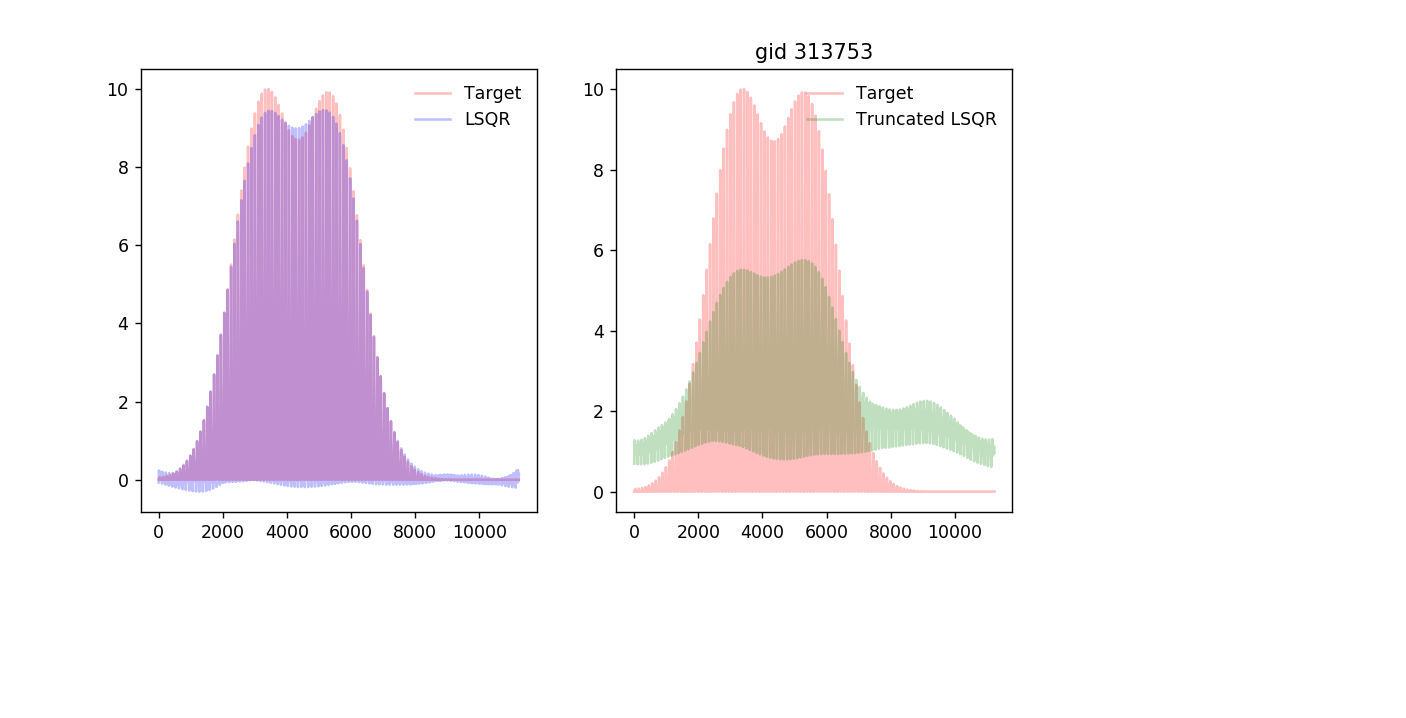

<IPython.core.display.Javascript object>


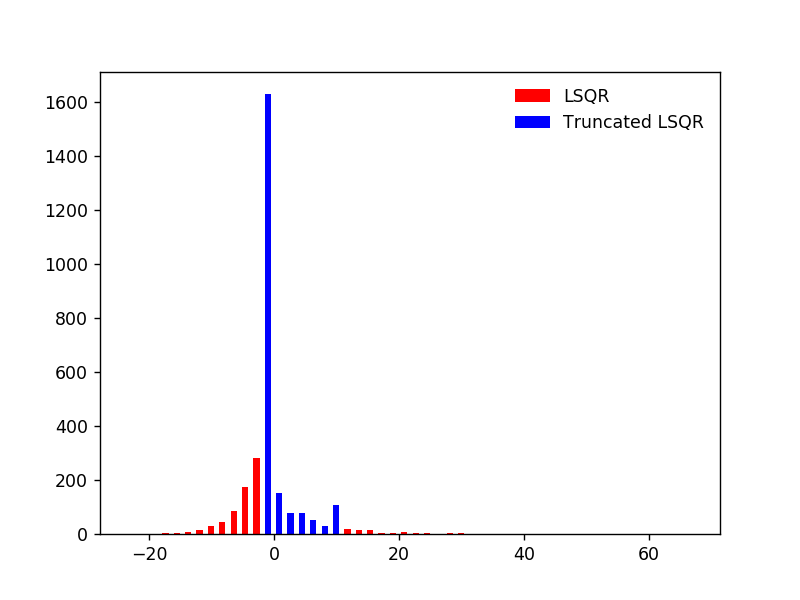

<IPython.core.display.Javascript object>


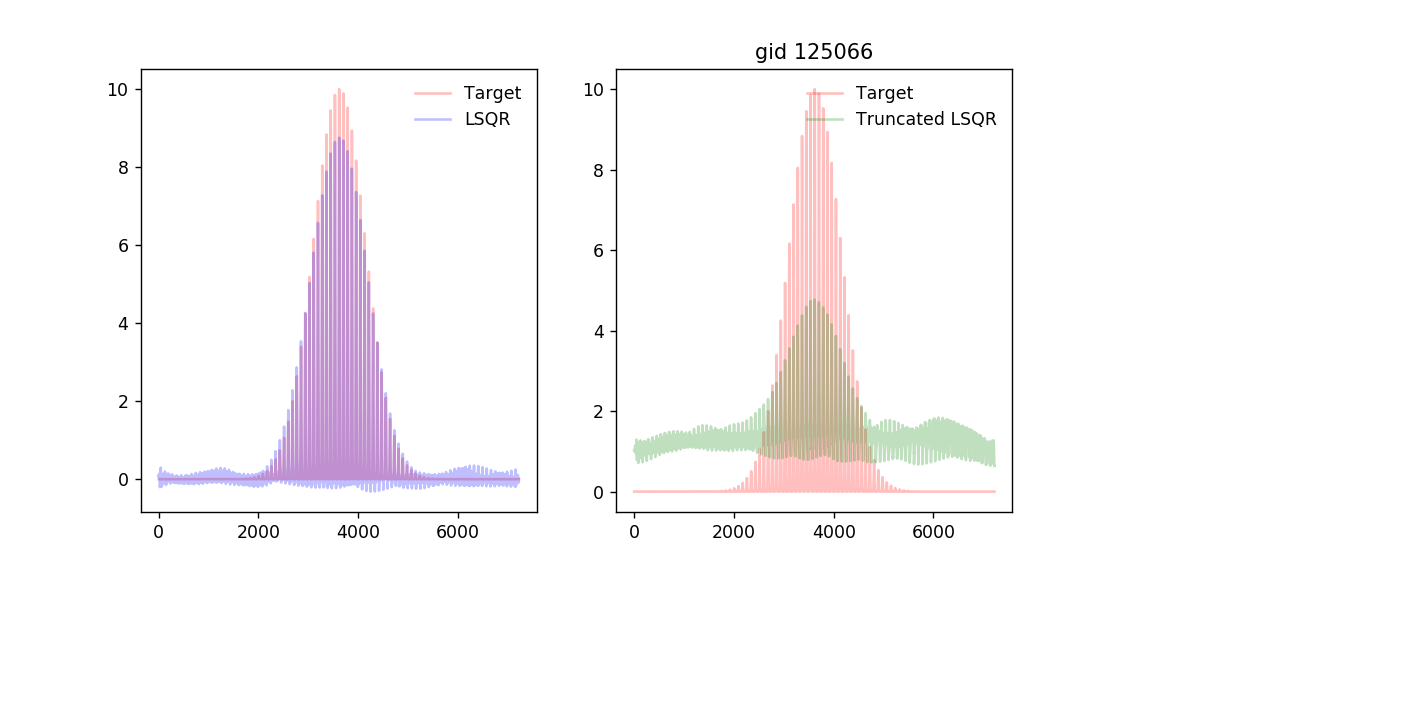

<IPython.core.display.Javascript object>


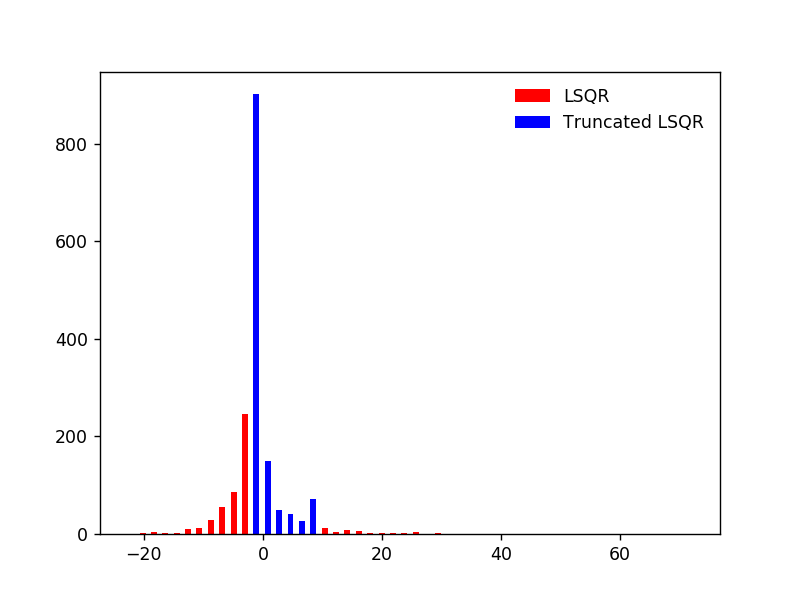

<IPython.core.display.Javascript object>


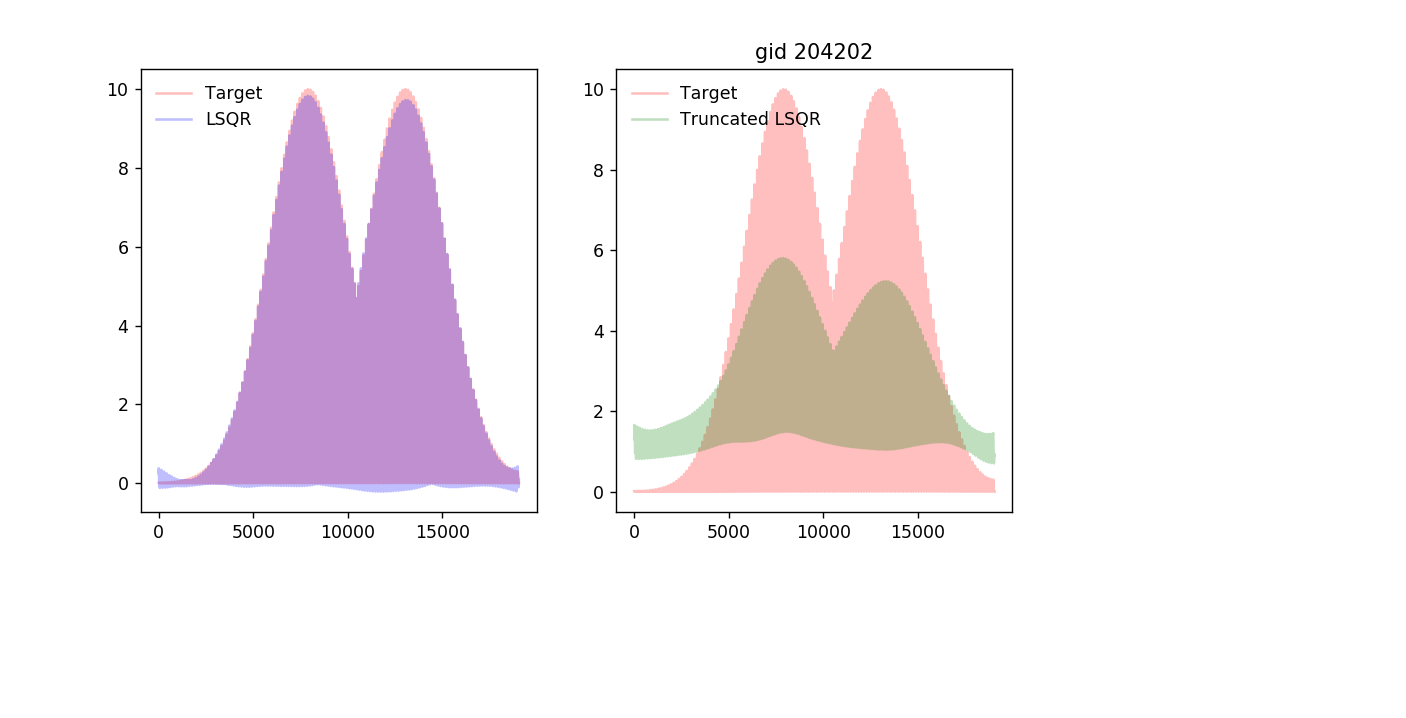

<IPython.core.display.Javascript object>


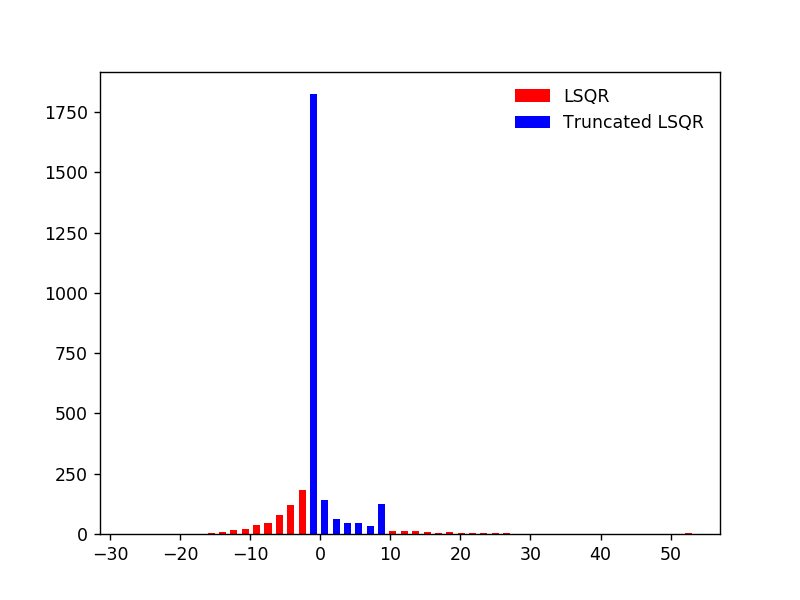

<IPython.core.display.Javascript object>


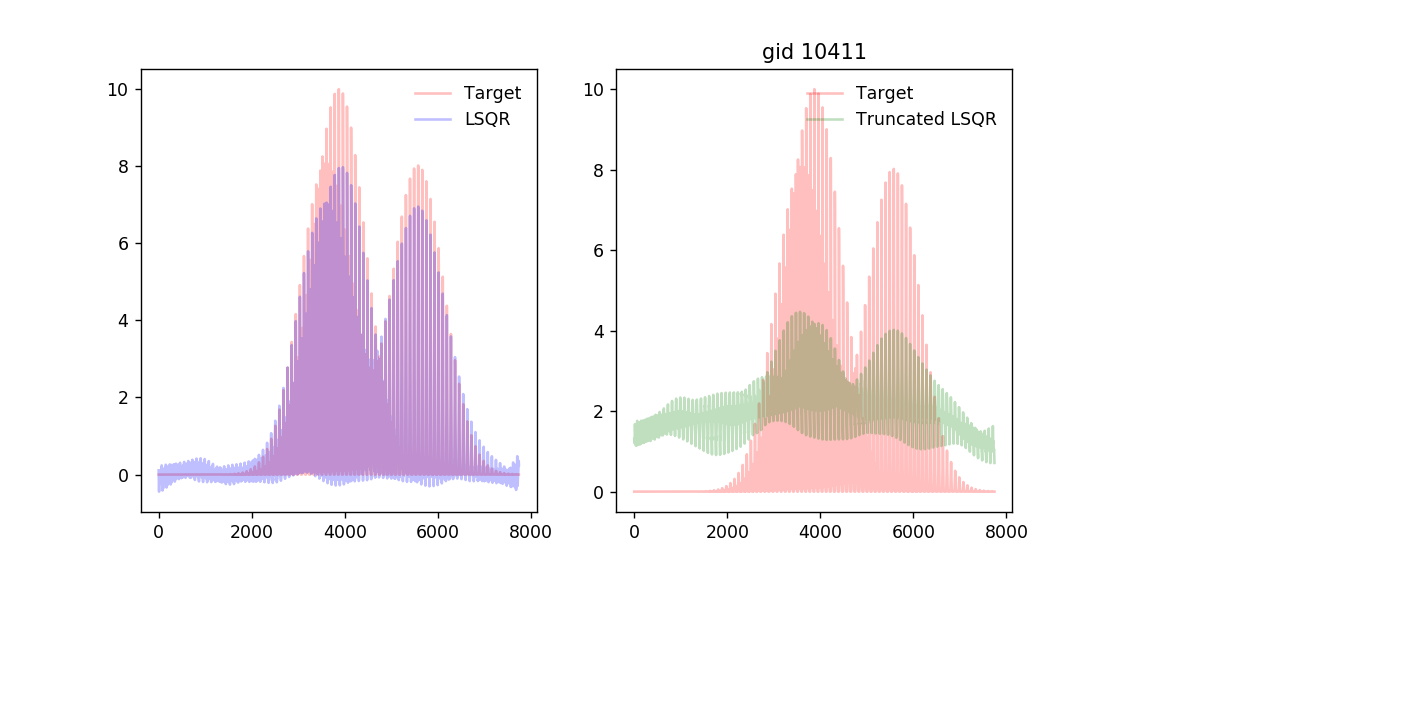

<IPython.core.display.Javascript object>


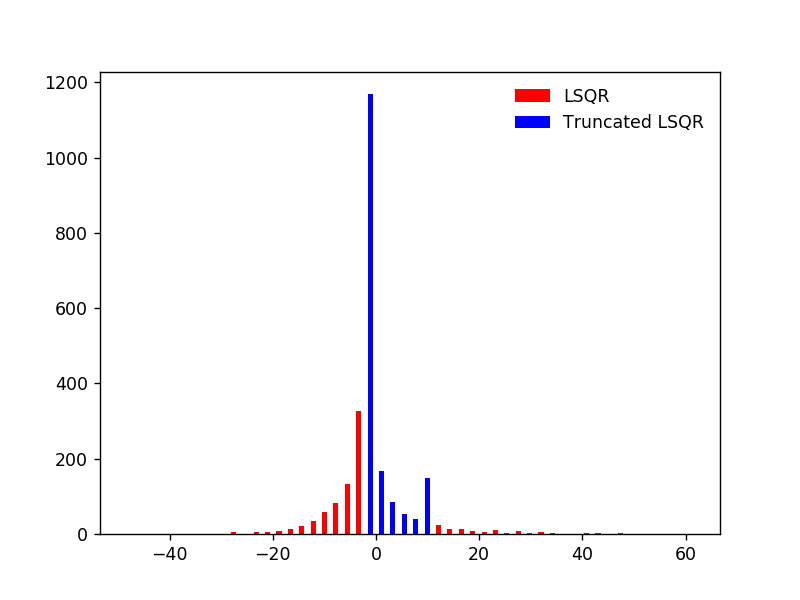

<IPython.core.display.Javascript object>


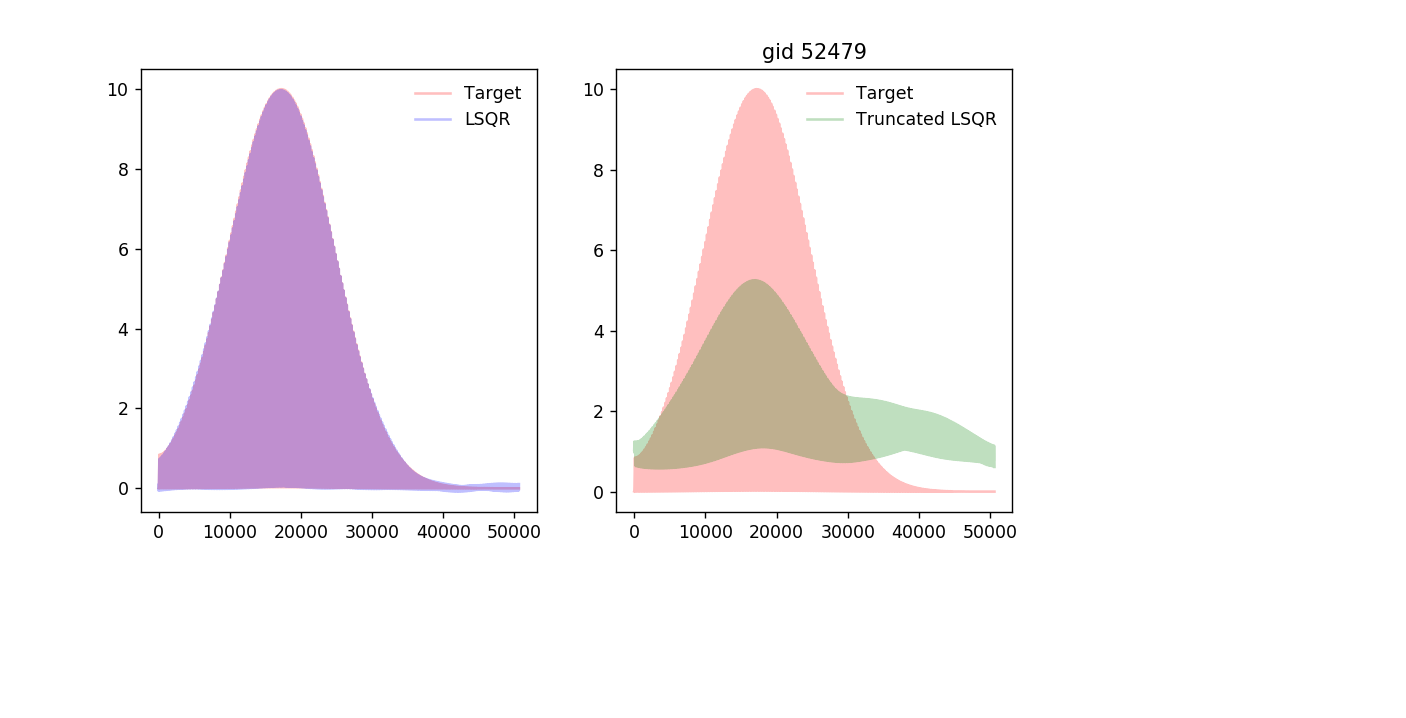

<IPython.core.display.Javascript object>


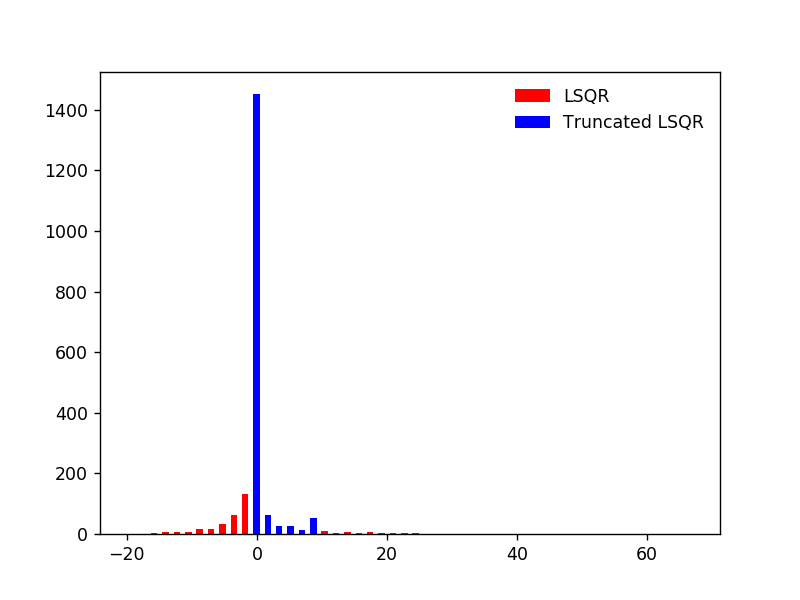

In [17]:
for gid, lsqr_arrays in lsqr_dict.items():

    lsqr_delta_weights = lsqr_arrays['lsqr_delta_weights']
    scaled_maps = scaled_maps_dict[gid]
    scaled_target_map = scaled_maps['flat_scaled_target_map']
    scaled_background_map = scaled_maps['scaled_background_map']
    scaled_input_matrix = scaled_maps['scaled_input_matrix']
    scaled_non_structured_input_matrix = scaled_maps['scaled_non_structured_input_matrix']
    
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    initial_weight_array = input_arrays_dict['initial_weight_array']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']

    lb = 0.
    ub = max_delta_weight
    initial_LS_bounds = (lb, ub)
    initial_LS_delta_weights = np.clip(lsqr_delta_weights, initial_LS_bounds[0], initial_LS_bounds[1])
    lsqr_arrays['initial_LS_delta_weights'] = initial_LS_delta_weights

    lsqr_map = np.dot(scaled_input_matrix, lsqr_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        lsqr_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        initial_LS_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)

    
    fig, axes = plt.subplots(1, 2, figsize=(9., 4.6))
    plt.title(f'gid {gid}')
    axes[0].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[1].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[0].plot(lsqr_map, c='b', alpha=0.25, label='LSQR')
    axes[1].plot(initial_LS_map, c='g', alpha=0.25, label='Truncated LSQR')
    axes[0].legend(loc='best', frameon=False, framealpha=0.5)
    axes[1].legend(loc='best', frameon=False, framealpha=0.5)

    plt.figure()
    hist, edges = np.histogram(lsqr_delta_weights, bins=50)
    plt.bar(edges[:-1], hist, color='r', width=1, label='LSQR')
    hist, edges = np.histogram(initial_LS_delta_weights, bins=edges)
    plt.bar(edges[:-1], hist, color='b', width=1, label='Truncated LSQR')
    plt.legend(loc='best', frameon=False, framealpha=0.5)


In [19]:
import scipy.optimize as opt
optimize_method = 'L-BFGS-B'

method_options = {'disp': True, 'maxiter': 1000}
method_options['maxfun'] = 1000000

LS_weights_dict = {}
for gid, lsqr_arrays in lsqr_dict.items():
    lsqr_target_map = lsqr_arrays['lsqr_target_map']
    initial_LS_delta_weights = lsqr_arrays['initial_LS_delta_weights']
    scaled_input_matrix = scaled_maps_dict[gid]['scaled_input_matrix']
    result = opt.minimize(activation_map_residual,
                          initial_LS_delta_weights, 
                          jac=activation_map_residual_grad if optimize_grad else None,
                          args=(scaled_input_matrix, lsqr_target_map.flat),
                          method=optimize_method,
                          bounds=[initial_LS_bounds for x in initial_LS_delta_weights],
                          tol=optimize_tol,
                          options=method_options)
    LS_weights_dict[gid]  = {'LS_delta_weights': np.array(result.x)}


max_delta_weight would have to increase to 19.5 to reach target_amplitude


<IPython.core.display.Javascript object>


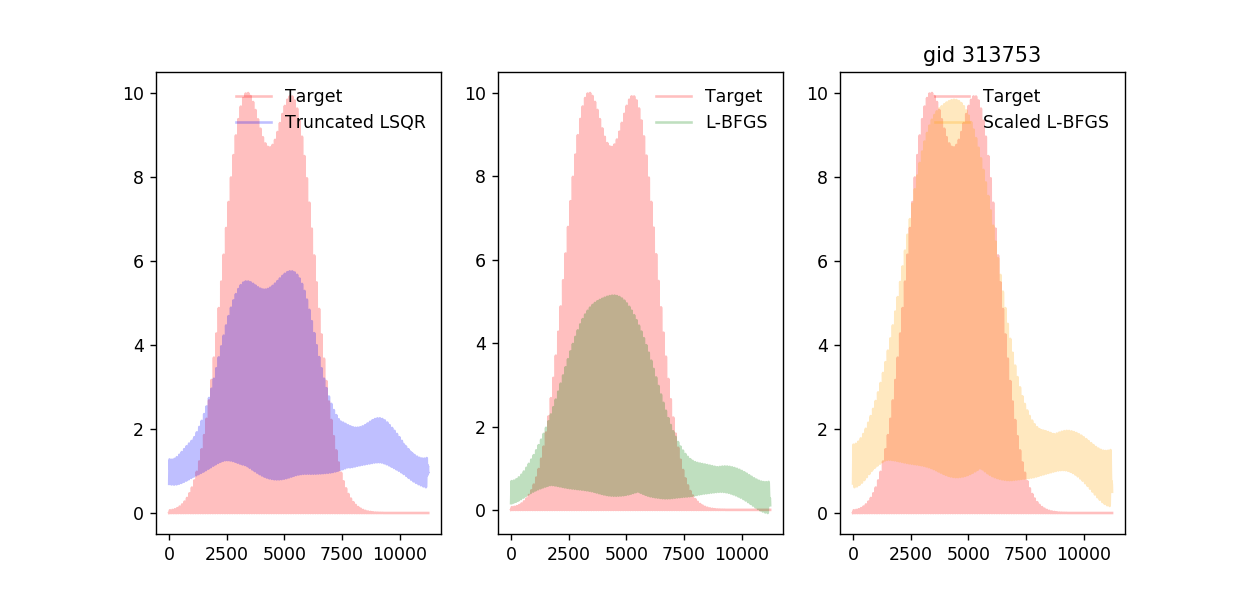

<IPython.core.display.Javascript object>


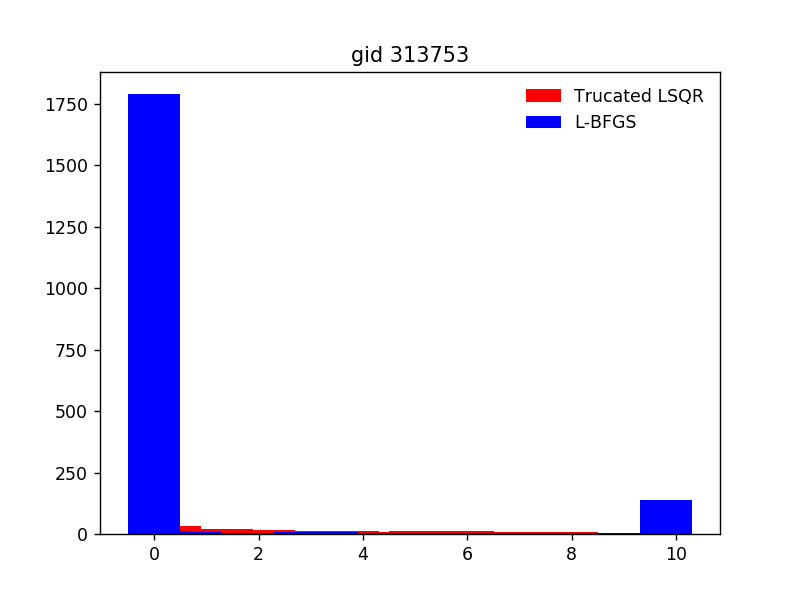

max_delta_weight would have to increase to 29.9 to reach target_amplitude


<IPython.core.display.Javascript object>


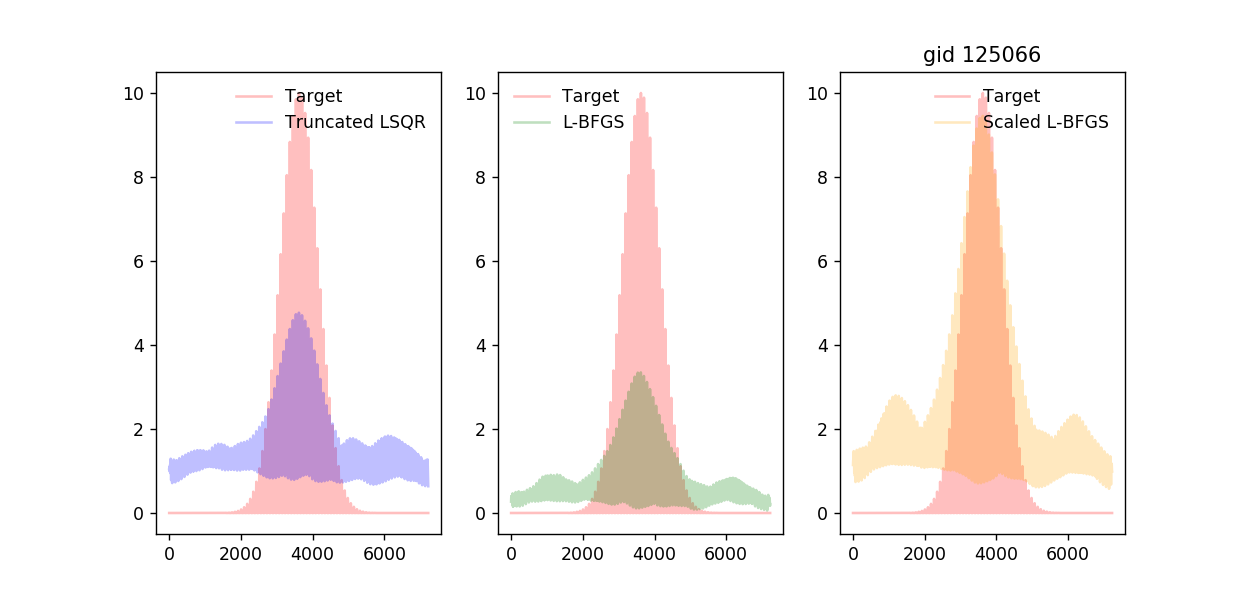

<IPython.core.display.Javascript object>


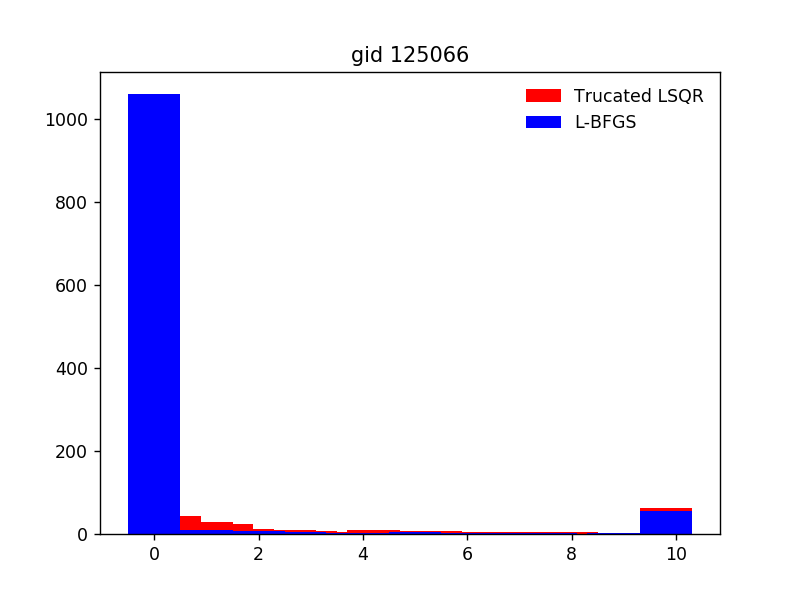

max_delta_weight would have to increase to 18.5 to reach target_amplitude


<IPython.core.display.Javascript object>


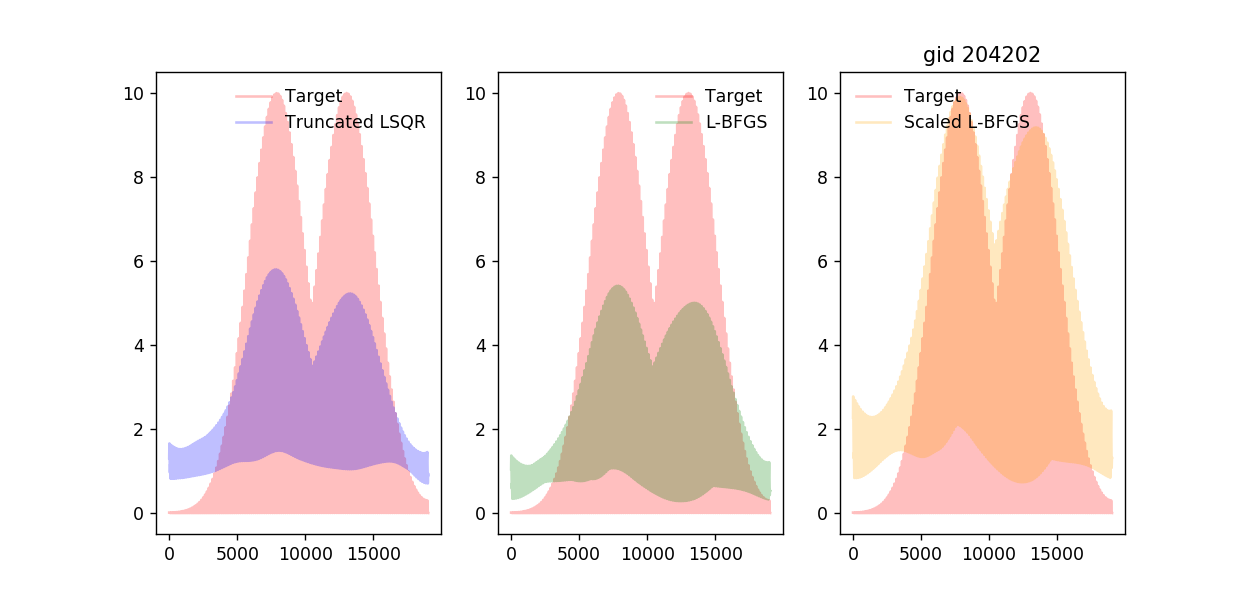

<ipython-input-20-f54e84a243cd>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


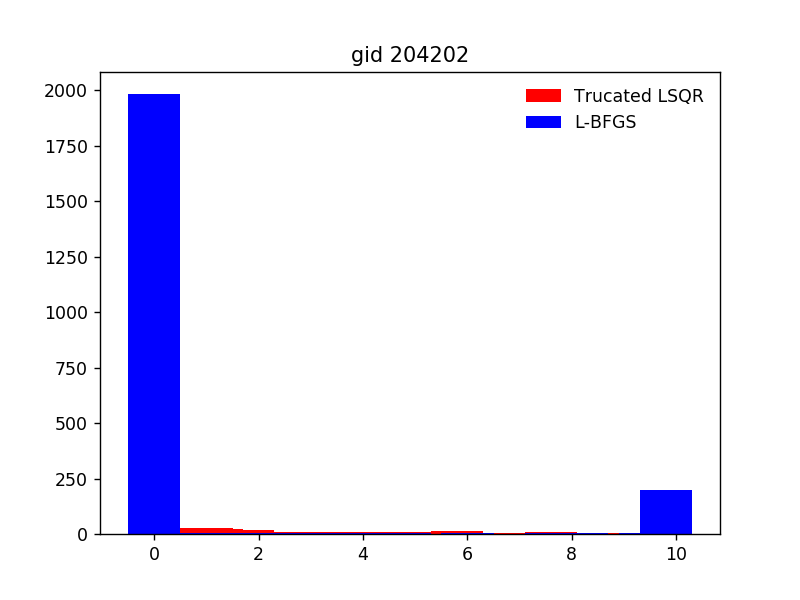

max_delta_weight would have to increase to 33.9 to reach target_amplitude


<ipython-input-20-f54e84a243cd>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 3, figsize=(10., 4.8))


<IPython.core.display.Javascript object>


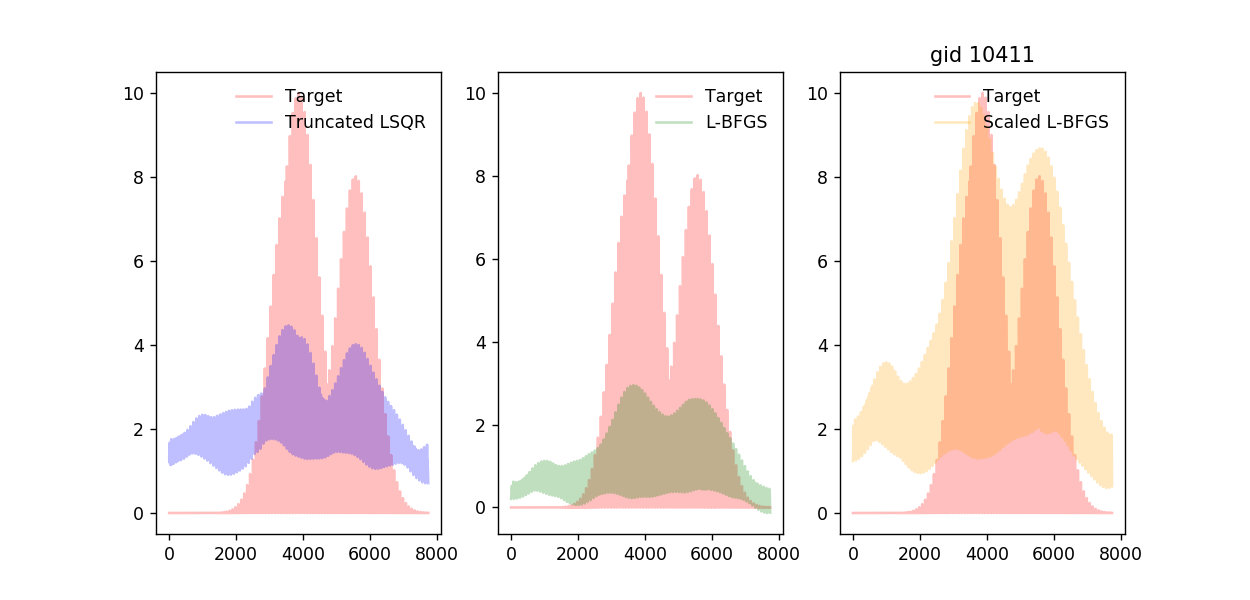

<IPython.core.display.Javascript object>


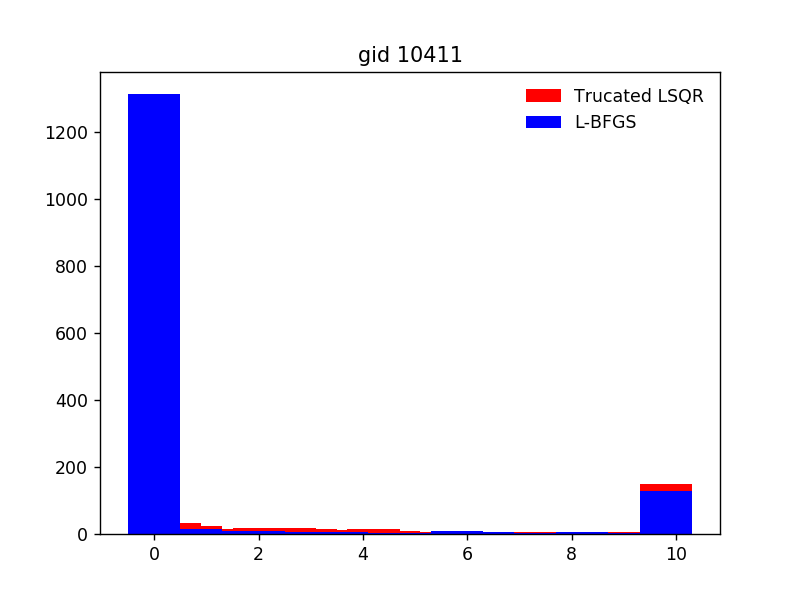

max_delta_weight would have to increase to 18.1 to reach target_amplitude


<IPython.core.display.Javascript object>


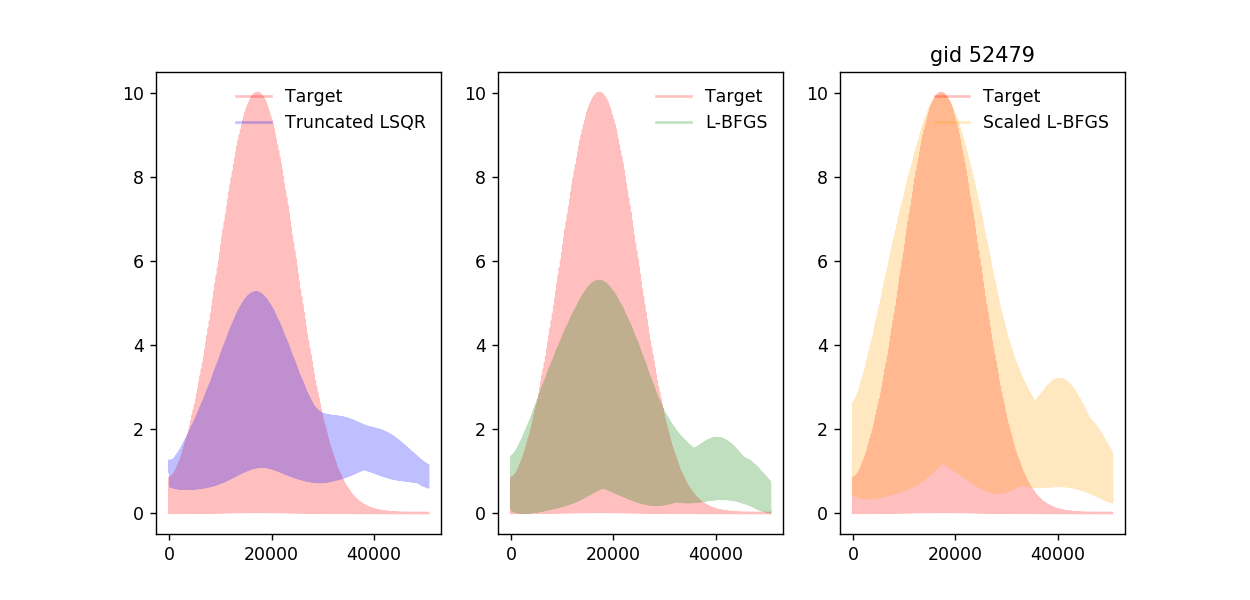

<IPython.core.display.Javascript object>


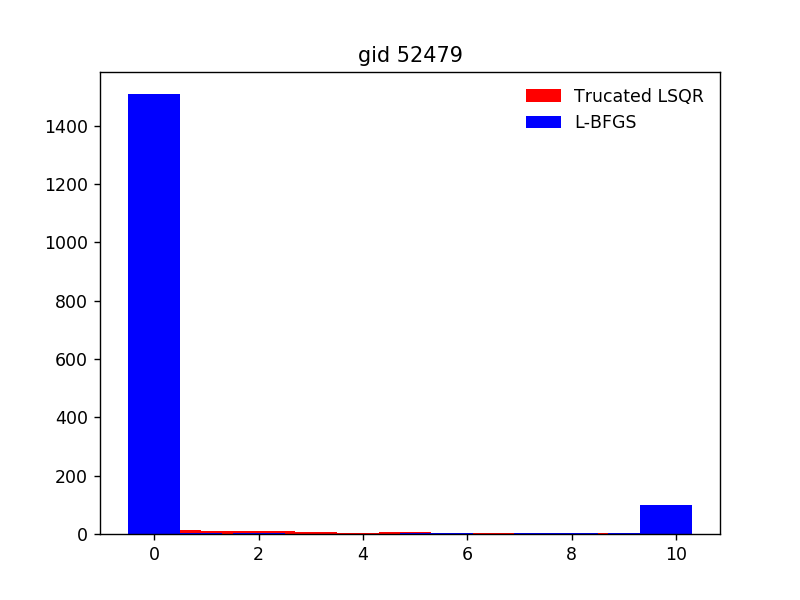

In [20]:
for gid, LS_arrays in LS_weights_dict.items():
    
    LS_delta_weights = LS_arrays['LS_delta_weights']
    
    scaled_maps = scaled_maps_dict[gid]
    scaled_input_matrix = scaled_maps['scaled_input_matrix']
    scaled_non_structured_input_matrix = scaled_maps['scaled_non_structured_input_matrix']
    scaled_target_map = scaled_maps['flat_scaled_target_map']
 
    input_arrays_dict = get_input_arrays(structured_weights_dict, gid)
    initial_weight_array = input_arrays_dict['initial_weight_array']
    non_structured_weight_array = input_arrays_dict['non_structured_weight_array']

    lsqr_arrays = lsqr_dict[gid]
    initial_LS_delta_weights = lsqr_arrays['initial_LS_delta_weights']

    LS_delta_map = np.dot(scaled_input_matrix, LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        LS_delta_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)

    
    initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        initial_LS_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    
    normalized_delta_weights_array = LS_delta_weights / np.max(LS_delta_weights)
    scaled_LS_delta_weights = LS_delta_weights * target_amplitude / np.max(LS_delta_map)
    
    scaled_LS_delta_map = np.dot(scaled_input_matrix, scaled_LS_delta_weights + initial_weight_array) - 1
    if scaled_non_structured_input_matrix is not None:
        scaled_LS_delta_map += np.dot(scaled_non_structured_input_matrix, non_structured_weight_array)
    print('max_delta_weight would have to increase to %.1f to reach target_amplitude' % (np.max(scaled_LS_delta_weights))) 

    fig, axes = plt.subplots(1, 3, figsize=(10., 4.8))
    plt.title('gid %d' % gid)
    axes[0].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[1].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[2].plot(scaled_target_map, c='r', alpha=0.25, label='Target')
    axes[0].plot(initial_LS_map, c='b', alpha=0.25, label="Truncated LSQR")
    axes[1].plot(LS_delta_map, c='g', alpha=0.25, label="L-BFGS")
    axes[2].plot(scaled_LS_delta_map, c='orange', alpha=0.25, label="Scaled L-BFGS")
    axes[0].legend(loc='best', frameon=False, framealpha=0.5)
    axes[1].legend(loc='best', frameon=False, framealpha=0.5)
    axes[2].legend(loc='best', frameon=False, framealpha=0.5)

    plt.figure()
    plt.title('gid %d' % gid)
    hist, edges = np.histogram(initial_LS_delta_weights, bins=50)
    plt.bar(edges[:-1], hist, color='r', width=1, label='Trucated LSQR')
    hist, edges = np.histogram(LS_delta_weights, bins=edges)
    plt.bar(edges[:-1], hist, color='b', width=1, label='L-BFGS')
    plt.legend(loc='best', frameon=False, framealpha=0.5)